#  Final Project 

 #### Haris Rizvanski, M-N : 3290832

### Introduction:

This exercise is based on the article "Variable Selection and Corporate Bankruptcy Forecasts" published by Shaonan Tian, Yan Yu and Hui Guo in the Journal of Banking & Finance. The main goal of the authors is to investigate certain bankruptcy predicting variables, which have been previously used in the finance literature, and establish which are the most important for predicting financial defaults. As a result of large costs associated with bank failures and financial crises, this topic of variable selection has become very important, not only for corporations, but also for policy makers. One of the most relevant and recent events that has increased the need for applying state-of-the-art machine learning methods in the field of finance is the global recession of 2008/2009. After this period, many regulatory institutions have imposed more strict rules which all of the banks and firms need to obey, and made sure that such scenarios are assessed and anticipated beforehand. 

The main challenge in the corporate bankruptcy forecasting models is that there is a large number of primary variables specified. Finance researchers have previously used variables which were constructed based on both accounting and market data. 
Even today, there is an ongoing debate about whether accounting variables or market-based variables are more relevant. This raises the concerns that the dimensionality of the data may exceed the length of the sample size, potentially causing model overfitting As a result, through time, many variables have been changed and improvements have been made. To find a solution for this issue, the authors use advanced variable selection technique, the LASSO method, with the aim of identifying the most relevant variables and improving the prediction accuracy.

Two widely used shrinkage methods in econometrics and statistics are Ridge and LASSO. They have similarities and differences, but when it comes to variable selection, the LASSO method is better because it is able to shrink the non-relevant coefficients to zero and select only the variables which have more influence over the outcome variable. Additionally, this method solves the issue of multicollinearity, which is one of the main issues when considering financial distress predicting variables. This is the reason why the authors have decided to use this method, as it gives an answer to the question of which are the most important variables in predicting financial default and bankruptcy. 

In this exercise we try to establish whether this advanced variable selection technique performs better when compared with the initial regression models. We first take a look at the difference between the logistic regression and the LASSO variable selection technique. Furthermore, we compare the LASSO model with the model suggested by CHS with selected variables. As a robustness check, we take a subsample of the data and compare the models accordingly. At the end, we perform a small simulation study by increasing the number of regressors and defining different time horizons for the outcome variable. We use the performance measures which are suggested by the authors in the paper.                     

### Packages used:

In [ ]:
install.packages("MASS")
install.packages("data.table")
install.packages("tidyverse")
install.packages("DescTools")
install.packages("magrittr")
install.packages("dplyr")
install.packages("maxLik")
install.packages("pROC")
install.packages("glmnet")
install.packages("ROCR")
install.packages("qpcR")

### 1. Data:

Since I was not able to access the original data used in the paper, the steps of creating the data bellow tries to replicate the original dataset. This panel data set contains observations on year/period basis for 100 firms. The data is generated for the period between 1980-2009. For each firm, there is an entry containing information related with bankruptcy and financial well-being. There are in total 39 explanatory continuous variables and 1 dependent binomial variable for bankruptcy. In total, this artificial bankruptcy database contains 9000 observations for 100 firms.


#### Data Generating Process:

In the Data Generating process, there are in total $39$ covariates, $9000$ observations and uniformly distributed coefficients in the $[-5, 5]$ interval. The error term is normally distributed with $sd = 5$. Additionally, I decided to create non-linear data using the polynomial function. We can see that $X$ is constructed with a polynomial function, using the number of regressors as arguments.  

To estimate the default risk, there needs to be an indicator for bankruptcy. In the paper, the authors constructed this variable based on information from the protection codes available to them, whether the firms have filed for bankruptcy or not. This variable takes the value of one when firms have filed for bankruptcy and the value of zero otherwise. Because of information unavailability, the outcome variable under my setup is determined based on a logit regression. The reason why I have decided to generate the outcome variable as such is because in the paper it is assumed that there is a logistic regression link between the outcome variable and time-varying covariates. Hence, given the values of the dependent variables, for each firm in each period the outcome variable takes the value of one or zero based on a logit function.

In [152]:
set.seed(123)
n <- 9000                          #number of observations
p <- 39                            #number of bankruptcy predicting measurements
beta <- runif(p,-5,5)              #true beta coefficients, uniformly distributed

DataGeneratingProcess <- function(N, P, Beta, Mu, Sig){
  eps <- rnorm(n ,mean=0, sd= 5)   #normally distributed error term
  mu <- rep(Mu,p)
  sig <- diag(Sig^2, p, p)
  X <- cbind(poly(rnorm(n, 0, sqrt(4)),p, raw = TRUE))
  z = X %*% beta + eps             # linear combination with a bias
  pr = 1/(1+exp(-z))               # pass through an inv-logit function
  Y = rbinom(9000,1,pr)            # creating a binary outcome variable
  data <- data.frame("Y"=Y, "X"=X)
  return(data)
}

library(MASS)                      #storing the data
data <- DataGeneratingProcess(N = n, P = p, Beta = beta, Mu = 0, Sig = 1)

#### Creating Panel Variables:

I decided to split the years in three periods, each containing four months, which together with the 100 firm indices gave me a large enough sample size.

In [153]:
Firmid <- c(1:100)                  #in total 100 firm indices
                                    #year/period observations for the period 1980-2009
year <- c("1980/1", "1980/2", "1980/3", "1981/1","1981/2","1981/3", "1982/1", "1982/2", "1982/3", "1983/1", "1983/2",
          "1983/3", "1984/1", "1984/2", "1984/3", "1985/1", "1985/2", "1985/3", "1986/1", "1986/2", "1986/3","1987/1",
          "1987/2" ,"1987/3","1988/1","1988/2","1988/3","1989/1","1989/2","1989/3","1990/1","1990/2","1990/3","1991/1",
          "1991/2","1991/3","1992/1","1992/2","1992/3","1993/1","1993/2","1993/3","1994/1","1994/2","1994/3","1995/1",
          "1995/2","1995/3","1996/1","1996/2","1996/3","1997/1","1997/2","1997/3","1998/1","1998/2","1998/3","1999/1","1999/2","1999/3","2000/1",
          "2000/2","2000/3","2001/1","2001/2","2001/3","2002/1","2002/2","2002/3","2003/1","2003/2","2003/3","2004/1","2004/2","2004/3",
          "2005/1","2005/2","2005/3","2006/1","2006/2","2006/3","2007/1","2007/2","2007/3","2008/1","2008/2","2008/3",
          "2009/1","2009/2","2009/3")

paneldata <- merge(Firmid, year)    #merging them together

library(data.table)                 #sorting the panel variables
dt <- data.table(paneldata, key = 'x')
sorted <- dt[, list(Y = sort(y)), by = 'x']

moddata <- data.frame(sorted,data)  #combining them together with the generated data above

#### Renaming the Variables:

When renaming the variables, I have used the information available in Table 1, page 92. In this table we can find their names and short descriptions.

In [154]:
library(tidyverse)                  #renaming the variables
renamed_data <- dplyr::rename(moddata,FirmID = x, `Year/Period` = Y, BANKRUPTCY = Y.1, ACTLCT = X.1,APSALE = X.2, CASHAT = X.3, CASHMTA = X.4, CHAT = X.5, CHLCT =X.6, 
                       `EBIT+DP/AT` = X.7, EBITAT = X.8, EBITSALE = X.9, EXCESSRETURN = X.10, FAT = X.11,
                       FFOLT = X.12, INVCHINVT = X.13, INVTSALE = X.14, `(LCT-CH)/AT` = X.15, LCTAT = X.16,
                       LCTLT = X.17, LCTSALE = X.18, `LT/(LT + MKET)` = X.19, LTAT = X.20, LTMTA = X.21,
                       "LOG(AT)" = X.22, `LOG(SALE)` = X.23, MB = X.24, MVEF = X.25, NIAT = X.26, NIMTA = X.27,
                       NISALE = X.28, OIADPAT = X.29, OIADPSALE = X.30, PRICE = X.31, QALCT = X.32,
                       REAT = X.33, RELCT = X.34, RSIZE = X.35, SALEAT = X.36, SEQAT = X.37, SIGMA = X.38,
                       WCAPAT = X.39)

#### Final Data:

The table below shows the finalized version of the data. In total, there are 42 variables and 9000 observations. This is a panel data containing information for 100 firms. The FirmID variable indicates which firm is taken into consideration. The Year/Period variable separates the years in three sub-periods and gives in total 90 observations for each firm. $BANKRUPTCY$ is the main outcome variable. All of the other 39 explanatory variables contain information for the firms and their financial well-being.

Note: Given the fact that this is artificial data, the values in each variable are not as precise as in the paper and not based on real accounting and market data.

In [155]:
renamed_data

FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,OIADPSALE,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980/1,0,0.07500664,0.005625996,0.000421987,3.165183e-05,2.374097e-06,1.780731e-07,1.335666e-08,...,1.790569e-34,1.343046e-35,1.007373e-36,7.555969e-38,5.667478e-39,4.250985e-40,3.188521e-41,2.391602e-42,1.793861e-43,1.345515e-44
1,1980/2,1,1.11033424,1.232842116,1.368866809,1.519900e+00,1.687597e+00,1.873796e+00,2.080540e+00,...,2.310000e+01,2.564872e+01,2.847865e+01,3.162082e+01,3.510968e+01,3.898348e+01,4.328469e+01,4.806047e+01,5.336319e+01,5.925098e+01
1,1980/3,1,-0.96620598,0.933554003,-0.902005463,8.715231e-01,-8.420708e-01,8.136139e-01,-7.861186e-01,...,3.565264e-01,-3.444779e-01,3.328366e-01,-3.215888e-01,3.107210e-01,-3.002205e-01,2.900748e-01,-2.802720e-01,2.708005e-01,-2.616491e-01
1,1981/1,0,3.39501447,11.526123263,39.131355281,1.328515e+02,4.510328e+02,1.531263e+03,5.198660e+03,...,8.418775e+15,2.858186e+16,9.703584e+16,3.294381e+17,1.118447e+18,3.797144e+18,1.289136e+19,4.376635e+19,1.485874e+20,5.044563e+20
1,1981/2,0,-1.50604329,2.268166398,-3.415956790,5.144579e+00,-7.747958e+00,1.166876e+01,-1.757366e+01,...,2.163335e+05,-3.258075e+05,4.906803e+05,-7.389857e+05,1.112945e+06,-1.676143e+06,2.524343e+06,-3.801770e+06,5.725631e+06,-8.623048e+06
1,1981/3,1,0.19272891,0.037144434,0.007158807,1.379709e-03,2.659098e-04,5.124851e-05,9.877070e-06,...,3.535137e-22,6.813231e-23,1.313107e-23,2.530736e-24,4.877460e-25,9.400277e-26,1.811705e-26,3.491680e-27,6.729476e-28,1.296965e-28
1,1982/1,1,-0.62565332,0.391442080,-0.244907038,1.532269e-01,-9.586692e-02,5.997946e-02,-3.752635e-02,...,7.762697e-07,-4.856757e-07,3.038646e-07,-1.901139e-07,1.189454e-07,-7.441859e-08,4.656024e-08,-2.913057e-08,1.822564e-08,-1.140293e-08
1,1982/2,0,2.45333698,6.018862343,14.766297571,3.622670e+01,8.887631e+01,2.180435e+02,5.349343e+02,...,4.928516e+11,1.209131e+12,2.966406e+12,7.277593e+12,1.785439e+13,4.380283e+13,1.074631e+14,2.636432e+14,6.468056e+14,1.586832e+15
1,1982/3,0,1.83614286,3.371420619,6.190409913,1.136648e+01,2.087048e+01,3.832117e+01,7.036315e+01,...,8.264072e+07,1.517402e+08,2.786166e+08,5.115799e+08,9.393338e+08,1.724751e+09,3.166889e+09,5.814861e+09,1.067692e+10,1.960434e+10


#### Data Descriptives:

As a short summary, we can take a look at how many times the firms have filed for bankruptcy in the period of 1980-2009. I randomly selected, $FirmID = 1$, $FirmID = 2$, $FirmID = 3$, $FirmID = 20$, $FirmID = 50$ and  $FirmID = 100$. For each of them I calculated the mean of $BANKRUPTCY$ across time and compared the average rates.

In [156]:
Bankruptcy <- renamed_data[,3]            #looking at the average rates of bankruptcy for firms across years
meandeno <- 90                            #used for computing the mean, in total 90 time periods for each firm

sum1 <- sum(Bankruptcy[1:90])             #firmID = 1
meanfirm1 <- sum1/meandeno

sum2 <- sum(Bankruptcy[91:180])           #firmID = 2
meanfirm2 <- sum2/meandeno

sum3 <- sum(Bankruptcy[181:270])          #firmID = 3
meanfirm3 <- sum3/meandeno

sum4 <- sum(Bankruptcy[1711:1800])        #firmID = 20
meanfirm4 <- sum4/meandeno

sum5 <- sum(Bankruptcy[4410:4500])        #firmID = 50
meanfirm5 <- sum5/meandeno

sum6 <- sum(Bankruptcy[8911:9000])        #firmID = 100
meanfirm6 <- sum6/meandeno


This graph shows which of the firms have the highest rate of bankruptcy in the time-period of 1980-2009. Among the randomly selected firms, $FirmID = 100$, has the highest average bankruptcy rate which equals to 0.544. That is, this firm has filed for bankruptcy more than all of the other randomly selected firms.

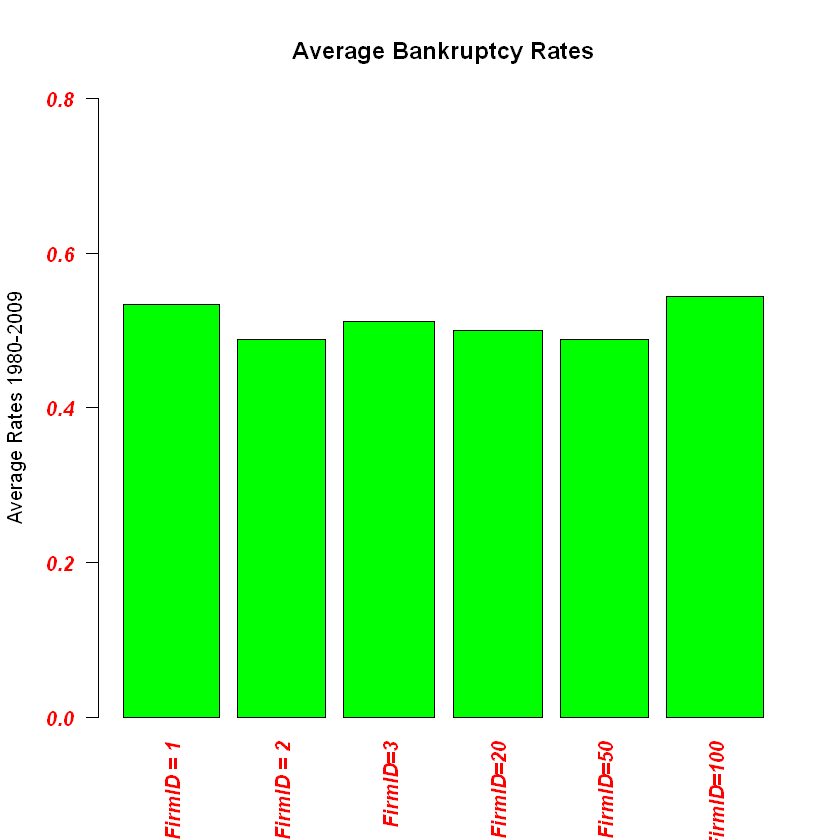

In [157]:
firms_bankruptcy <- c(meanfirm1, meanfirm2, meanfirm3, meanfirm4, meanfirm5, meanfirm6)

barplot(firms_bankruptcy, main="Average Bankruptcy Rates", ylim=c(0,0.8), ylab="Average Rates 1980-2009",
col="green", names.arg = c("FirmID = 1","FirmID = 2","FirmID=3","FirmID=20","FirmID=50","FirmID=100"),
height=firms_bankruptcy, font.axis=4, col.axis="red",cex.axis=1,las = 2)

#### Splitting the Data into a Train and Test set and creating a Lead for $Y$:

The data is randomly split into a train and test set. The train set contains 80%, whereas the test set contains 20% of the original data. The first subset is used to fit the model and the second for testing the performance of the model. Also, I create a lead for $Y$, given the fact that we predict one-year ahead default risk in the logistic model further on. After the split is done, we omit the NA variables. 

In [158]:
renamed_data$BANKRUPTCY <- lead(renamed_data$BANKRUPTCY, 3)      #creating lead for Bankruptcy


sample <- floor(0.80*nrow(renamed_data)) 
set.seed(124)                                                    #setting seed to make the partition reproducible
train_ind <- sample(seq_len(nrow(renamed_data)), size = sample)

train_data <- renamed_data[train_ind,]                           #train data
train_data <- na.omit(train_data)                                #omitting NA variables

test_data  <- renamed_data[-train_ind,]                          #test data
test_data <- na.omit(test_data)                                  #omitting NA variables

train_data                                                       #overview of the train and test data
test_data

,FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,OIADPSALE,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5441,61,1993/2,0,0.76333516,5.826806e-01,4.447806e-01,3.395166e-01,2.591650e-01,1.978297e-01,1.510104e-01,...,3.030107e-04,2.312987e-04,1.765585e-04,1.347733e-04,1.028772e-04,7.852977e-05,5.994454e-05,4.575777e-05,3.492852e-05,2.666216e-05
1002,12,1983/3,1,-3.90235490,1.522837e+01,-5.942652e+01,2.319034e+02,-9.049692e+02,3.531511e+03,-1.378121e+04,...,5.492916e+17,-2.143531e+18,8.364817e+18,-3.264248e+19,1.273826e+20,-4.970920e+20,1.939829e+21,-7.569902e+21,2.954044e+22,-1.152773e+23
2776,31,2005/1,0,1.29463149,1.676071e+00,2.169894e+00,2.809213e+00,3.636896e+00,4.708440e+00,6.095694e+00,...,2.314115e+03,2.995927e+03,3.878621e+03,5.021385e+03,6.500843e+03,8.416196e+03,1.089587e+04,1.410614e+04,1.826225e+04,2.364289e+04
5510,62,1986/2,0,0.41876418,1.753634e-01,7.343593e-02,3.075234e-02,1.287798e-02,5.392835e-03,2.258326e-03,...,4.561271e-12,1.910097e-12,7.998801e-13,3.349612e-13,1.402697e-13,5.873994e-14,2.459818e-14,1.030084e-14,4.313622e-15,1.806390e-15
1953,22,2000/3,1,2.45162891,6.010484e+00,1.473548e+01,3.612592e+01,8.856735e+01,2.171343e+02,5.323327e+02,...,4.826608e+11,1.183305e+12,2.901025e+12,7.112237e+12,1.743657e+13,4.274799e+13,1.048022e+14,2.569361e+14,6.299120e+14,1.544311e+15
1423,16,2004/1,0,-2.15566490,4.646891e+00,-1.001714e+01,2.159360e+01,-4.654856e+01,1.003431e+02,-2.163061e+02,...,1.017273e+10,-2.192900e+10,4.727157e+10,-1.019017e+11,2.196658e+11,-4.735259e+11,1.020763e+12,-2.200424e+12,4.743376e+12,-1.022513e+13
7003,78,2004/1,0,1.57336955,2.475492e+00,3.894863e+00,6.128059e+00,9.641702e+00,1.516996e+01,2.386795e+01,...,8.033823e+05,1.264017e+06,1.988766e+06,3.129064e+06,4.923174e+06,7.745973e+06,1.218728e+07,1.917509e+07,3.016950e+07,4.746778e+07
532,6,2007/1,0,1.68725562,2.846832e+00,4.803332e+00,8.104450e+00,1.367428e+01,2.307200e+01,3.892837e+01,...,6.537722e+06,1.103081e+07,1.861179e+07,3.140285e+07,5.298464e+07,8.939863e+07,1.508383e+08,2.545028e+08,4.294114e+08,7.245267e+08
6574,74,1981/1,1,-1.19841128,1.436190e+00,-1.721146e+00,2.062641e+00,-2.471892e+00,2.962343e+00,-3.550105e+00,...,2.281270e+02,-2.733900e+02,3.276336e+02,-3.926398e+02,4.705440e+02,-5.639052e+02,6.757904e+02,-8.098748e+02,9.705631e+02,-1.163134e+03


,FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,OIADPSALE,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1980/1,0,0.07500664,5.625996e-03,4.219870e-04,3.165183e-05,2.374097e-06,1.780731e-07,1.335666e-08,...,1.790569e-34,1.343046e-35,1.007373e-36,7.555969e-38,5.667478e-39,4.250985e-40,3.188521e-41,2.391602e-42,1.793861e-43,1.345515e-44
4,1,1981/1,1,3.39501447,1.152612e+01,3.913136e+01,1.328515e+02,4.510328e+02,1.531263e+03,5.198660e+03,...,8.418775e+15,2.858186e+16,9.703584e+16,3.294381e+17,1.118447e+18,3.797144e+18,1.289136e+19,4.376635e+19,1.485874e+20,5.044563e+20
5,1,1981/2,0,-1.50604329,2.268166e+00,-3.415957e+00,5.144579e+00,-7.747958e+00,1.166876e+01,-1.757366e+01,...,2.163335e+05,-3.258075e+05,4.906803e+05,-7.389857e+05,1.112945e+06,-1.676143e+06,2.524343e+06,-3.801770e+06,5.725631e+06,-8.623048e+06
27,1,1988/3,0,1.09728004,1.204023e+00,1.321151e+00,1.449673e+00,1.590697e+00,1.745440e+00,1.915236e+00,...,1.620035e+01,1.777632e+01,1.950560e+01,2.140310e+01,2.348520e+01,2.576984e+01,2.827673e+01,3.102749e+01,3.404585e+01,3.735783e+01
28,1,1989/1,1,1.05730179,1.117887e+00,1.181944e+00,1.249672e+00,1.321280e+00,1.396992e+00,1.477042e+00,...,5.320703e+00,5.625589e+00,5.947945e+00,6.288773e+00,6.649131e+00,7.030138e+00,7.432977e+00,7.858900e+00,8.309229e+00,8.785363e+00
36,1,1991/3,0,1.90184548,3.617016e+00,6.879006e+00,1.308281e+01,2.488148e+01,4.732072e+01,8.999670e+01,...,2.372777e+08,4.512655e+08,8.582372e+08,1.632234e+09,3.104258e+09,5.903819e+09,1.122815e+10,2.135421e+10,4.061240e+10,7.723852e+10
37,1,1992/1,0,1.17397485,1.378217e+00,1.617992e+00,1.899482e+00,2.229944e+00,2.617898e+00,3.073347e+00,...,1.229600e+02,1.443519e+02,1.694655e+02,1.989483e+02,2.335603e+02,2.741939e+02,3.218967e+02,3.778987e+02,4.436435e+02,5.208263e+02
50,1,1996/2,1,-2.26038855,5.109356e+00,-1.154913e+01,2.610552e+01,-5.900862e+01,1.333824e+02,-3.014961e+02,...,4.221754e+10,-9.542805e+10,2.157045e+11,-4.875759e+11,1.102111e+12,-2.491199e+12,5.631078e+12,-1.272842e+13,2.877118e+13,-6.503406e+13
58,1,1999/1,1,-4.81325075,2.316738e+01,-1.115104e+02,5.367276e+02,-2.583405e+03,1.243457e+04,-5.985072e+04,...,2.972724e+20,-1.430847e+21,6.887024e+21,-3.314897e+22,1.595543e+23,-7.679750e+23,3.696456e+24,-1.779197e+25,8.563721e+25,-4.121934e+26


### 2. Logistic Regression, LASSO and CHS model:

#### Logistic Regression:

With the aim of assessing firm's bankruptcy risk over a given future period, the authors have assumed that there is a logistic regression link between the binary outcome bankruptcy variable and the continuous covariates. Following suggestions from other relevant finance research literature, the most commonly used horizon for forecasting financial defaults of firms is one period ahead. As a result, the default indicator $BANKRUPTCY$ in this model is taken ahead in time for one year and predicted accordingly. 

The logistic model for one-year ahead default risk prediction is given by the following equation: 

\begin{equation}
\begin{aligned}
P({Y}_{it+3} = 1 | {Y}_{it+3 - 1} = 0, {X}_{i,t}) = {{e}^{{{\beta_0}} + {\beta}{X}_{i,t}} \over 1 + {e}^{{{\beta_0}} + {\beta}{X}_{i,t}} }
\end{aligned}
\end{equation}

${X}_{i,t}$ is the covariate vector containing all of the firm-specific explanatory variables that are observable at each period of the year for all of the firms. The subscript t denotes the first, second or third period of the year from 1980 to 2009. ${Y}_{i,t + 3}$ is the bankruptcy indicator, which equals to one if the firm files for bankruptcy in the third period of the year, given that it survived for the previous eight months. On the other hand, it takes the value of 0 if the firm does not file for bankruptcy in the same period.

Furthermore, we proceed with fitting the logit model on all explanatory variables to the full sample in the period 1980-2009. Afterwards, we take a look at the performance measures suggested by the authors. I report the $McFadden Pseudo R^2$, $AIC$, $Brier Score$ and the $Accuracy Rate$. 

In [159]:
train_data$BANKRUPTCY <- as.factor(train_data$BANKRUPTCY)        #creating a categorical outcome variable
test_data$BANKRUPTCY <- as.factor(test_data$BANKRUPTCY)          #categorical outcome for test data

is.factor(train_data$BANKRUPTCY)                                 #control
is.factor(test_data$BANKRUPTCY)

[1] TRUE

[1] TRUE

In [160]:
                                                                 #running the logit regression on all explanatory variables
logit_model <- glm(BANKRUPTCY ~ ACTLCT + APSALE + CASHAT + CASHMTA + CHAT + CHLCT + `EBIT+DP/AT` + EBITAT + EBITSALE + EXCESSRETURN + FAT +
                     FFOLT + INVCHINVT + INVTSALE + `(LCT-CH)/AT` + LCTAT + LCTLT + LCTSALE + `LT/(LT + MKET)` + LTAT + LTMTA +
                     `LOG(AT)` + `LOG(SALE)` + MB + MVEF + NIAT + NIMTA + NISALE + OIADPAT + OIADPSALE + PRICE + QALCT +
                     REAT + RELCT + RSIZE + SALEAT + SEQAT + SIGMA + WCAPAT, family="binomial", data=train_data) 

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


In [161]:
a <- summary(logit_model$aic)                                    #reporting AIC
a <- a[c(1,6)]
print("Min and Max value for AIC")
a                                                                #min and max for AIC

#exp(coef(logit_model))                                          #looking at the odd ratios
                       
library(maxLik)                                                  #McFadden’s Pseudo-R squared
null_model <- glm(BANKRUPTCY ~ 1, family = "binomial", data = train_data)
R_sq_McFadden <- 1-logLik(logit_model)/logLik(null_model)
print("McFadden Pseudo R^2")                                     #reporting McFadden's Psuedo R-squared  
R_sq_McFadden

train_Y_logit <- as.numeric(train_data$BANKRUPTCY)               #converting back Y into numeric for calculation of Brier Score
pred_prob <- predict(logit_model, type = 'response')
brierScore <- mean((pred_prob-train_Y_logit)^2)
print("Brier Score")
brierScore                                                       #reporting the Brier Score
      
                                                                 #testing the performance on test data        
probabilities <- logit_model %>% predict(test_data, type = "response")
predicted_classes <- ifelse(probabilities > 0.5, "1", "0")
ar_logit <- mean(predicted_classes == test_data$BANKRUPTCY)          
print("Accuracy Rate")
ar_logit                                                         #accuracy rate of the logit model

[1] "Min and Max value for AIC"


    Min.     Max. 
259155.8 259155.8 

[1] "McFadden Pseudo R^2"


'log Lik.' -24.97408 (df=37)

[1] "Brier Score"


[1] 1.502154

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


[1] "Accuracy Rate"


[1] 0.4811111

The AUC is the area under the receiver operating characteristic (ROC) curve. This area under ROC describes the relationship between the true positive rate, that is the ratio of samples that are correctly predicted and the false positive rate, the ratio of samples that are incorrectly predicted. This is a popular measure for the discriminatory power of the model. We use the AUC to evaluate a model's ability to discriminate between binary events and non-binary variables. It tells us how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. This a commonly used statistic that measures the performance of logistic models. We continue on with plotting the ROC curve and showing the value of the AUC measure.

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train_data$BANKRUPTCY, predictor = logit_model$fitted.values,     percent = TRUE, plot = TRUE, legacy.axes = TRUE, xlab = "True Positive Rate",     ylab = "False Positive Rate", col = "#377eb8", lwd = 2, print.auc = TRUE)

Data: logit_model$fitted.values in 3531 controls (train_data$BANKRUPTCY 0) < 3666 cases (train_data$BANKRUPTCY 1).
Area under the curve: 50.05%

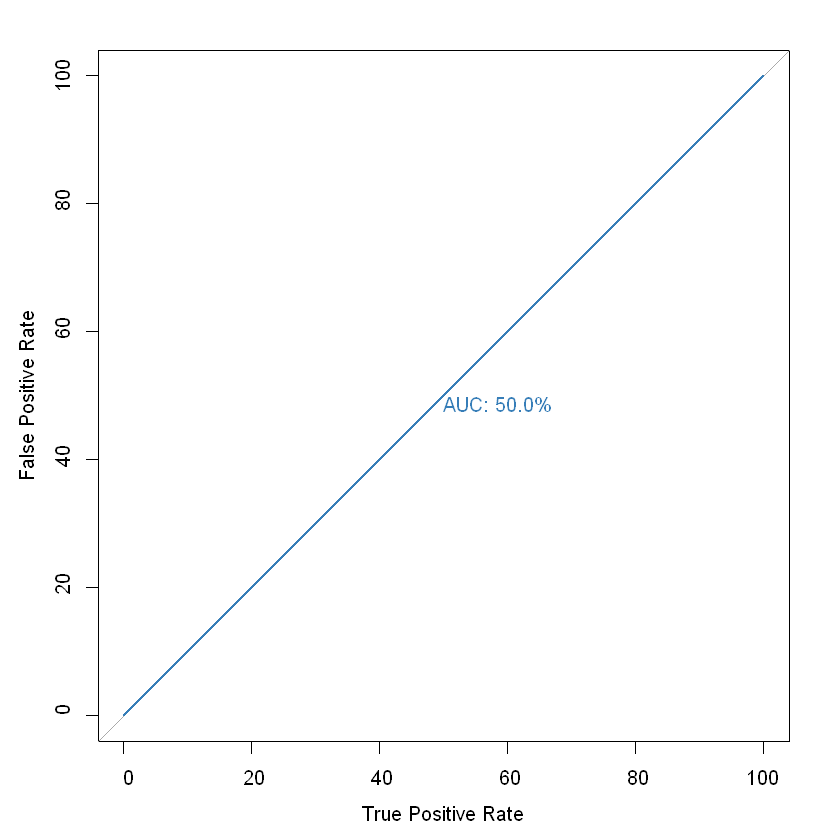

In [162]:
library(pROC)                                                     #reporting AUC
roc(train_data$BANKRUPTCY, logit_model$fitted.values, plot = TRUE, legacy.axes = TRUE,
    percent = TRUE, xlab = "True Positive Rate",                  #plotting ROC
    ylab = "False Positive Rate", col = "#377eb8", lwd = 2,
    print.auc = TRUE)

Just to have an overview of the data and the logistic regression, we can take a look at the following graph.

`geom_smooth()` using formula 'y ~ x'

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


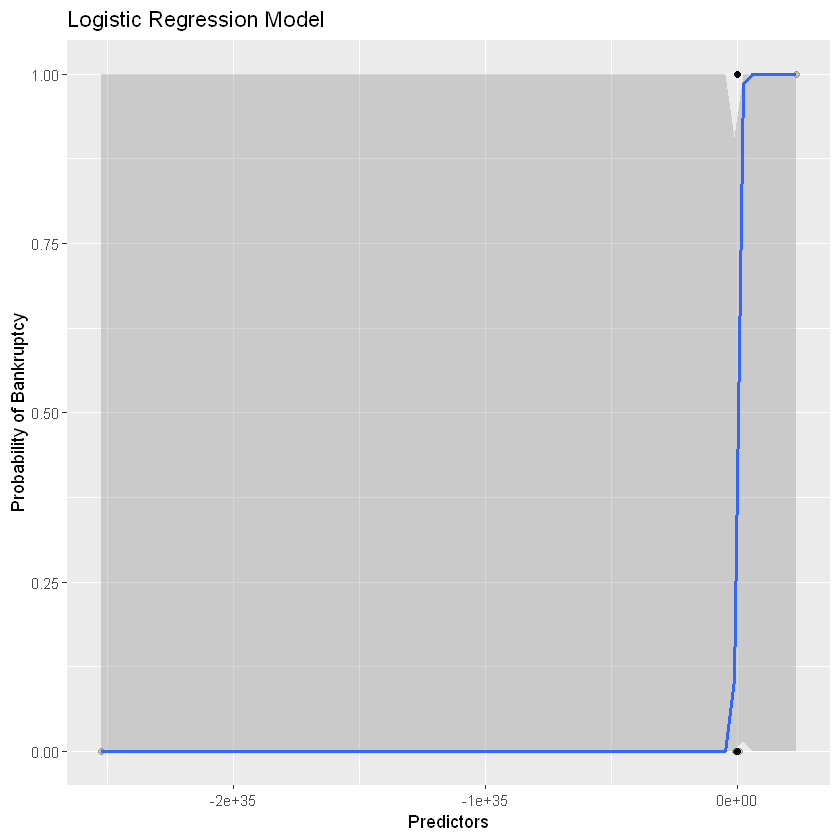

In [163]:
train_data %>% mutate(prob = ifelse(BANKRUPTCY == 1, 1, 0)) %>% ggplot(aes(ACTLCT + APSALE + 
CASHAT + CASHMTA + CHAT + CHLCT + `EBIT+DP/AT` + EBITAT + EBITSALE + EXCESSRETURN + FAT +
FFOLT + INVCHINVT + INVTSALE + `(LCT-CH)/AT` + LCTAT + LCTLT + LCTSALE + `LT/(LT + MKET)` + 
LTAT + LTMTA +`LOG(AT)` + `LOG(SALE)` + MB + MVEF + NIAT + NIMTA + NISALE + OIADPAT + OIADPSALE +
PRICE + QALCT + REAT + RELCT + RSIZE + SALEAT + SEQAT + SIGMA + WCAPAT, prob)) + geom_point(alpha = 0.2) +
geom_smooth(method = "glm", method.args = list(family = "binomial")) + 
labs( title = "Logistic Regression Model", y = "Probability of Bankruptcy" , x = "Predictors")

#### LASSO Model:

The word LASSO stands for "least absolute shrinkage and selection operator". It is a shrinkage operator because it aims to shrink the values of the coefficients to zero by adding a penalty to a certain regression model and it is a selection operator because it provides a sparse variable-set solution. One of the main advantages of this method is that the estimated models exhibit less variance and have more interpretable results with reduced set of predictors. 

The LASSO method adds a convex but non-smooth ${l}_{1}$ constraint to an unconstrained minimization problem. This penalty is equal to the absolute value of the magnitude of the coefficient. Hence, non-null coefficients in the initial regression model are bounded by this constraint. Some coefficients can become zero and get eliminated from the model. This helps reduce the number of the covariates included and provides a better prediction accuracy.  

This here represents the mathematical formula for this method, exhibiting the initial regression model and the added ${l}_{1}$ constraint. Since the authors have used logistic regression for predicting risk of default one period ahead, here we obtain LASSO parameter estimates by minimizing the negative log likelihood function. 


First of all, we have the negative log-likelihood function, 
\begin{equation}
\begin{aligned}
{\sum_{i=1}^n (-{Y}_{i,t + 3}({\beta}_{0} + {\beta}^{'}{X}_{i,t}) + log(1+exp({\beta}_{0} + {\beta}^{'}{X}_{i,t})))}
\end{aligned}
\end{equation}

subject to, 

\begin{equation}
\begin{aligned}
{\lambda \left(\sum_{k=1}^p |\beta_k|\right) \le s }
\end{aligned}
\end{equation}

which is equivalent to:
\begin{equation}
\begin{aligned}
{\sum_{i=1}^n (-{Y}_{i,t + 3}({\beta}_{0} + {\beta}^{'}{X}_{i,t}) + log(1+exp({\beta}_{0} + {\beta}^{'}{X}_{i,t}))) - \lambda \sum_{k=1}^p |\beta_k|}\\
\end{aligned}
\end{equation}

We control the amount of shrinkage through the roughness penalty tuning parameter $s$ or $\lambda$. This parameter controls for both the size and the number of coefficients that would be included in the model. When $\lambda = 0$, all variables are considered and we have the usual logistic regression from above. As $\lambda \rightarrow \infty$, the lasso regression coefficient estimates will approach zero and more variables would be eliminated. 

This captures the trade-off between variance and bias. Higher $\lambda$ increases the flexibility of the model and reduces its variance but at the cost of a higher model bias. When choosing this penalty parameter, most often used technique is cross-validation. This is a resampling technique that helps find a parameter value that ensures a proper balance between bias and variance. Cross-validation selects the parameter which minimizes the estimated test error rate of the estimator. 

Similarly as above, first we run the LASSO variable selection technique to the full sample spanning the 1980-2009 period with the appropriate functions in R and afterwards report the performance measures. 

In [164]:
train_X <- train_data[,4:42]                                      #extracting X variables
train_X <- as.matrix(train_X)                                     #converting into matrix form            
train_Y <- train_data[,3]                                         #extracting Y variable
train_Y <- as.matrix(train_Y)

Cross-Validation is performed based on the measure AUC. In cross-validation, a subset of the data observations, the training set, is used to estimate the model, and the remainder observations are held to serve as test set or validation set. This resampling method selects the optimal $\lambda$ as the one that minimizes the area under the ROC. In the lines bellow we can observe a 5-fold cross-validation.

[1] "Optimal Lambda"


[1] 0.002062154

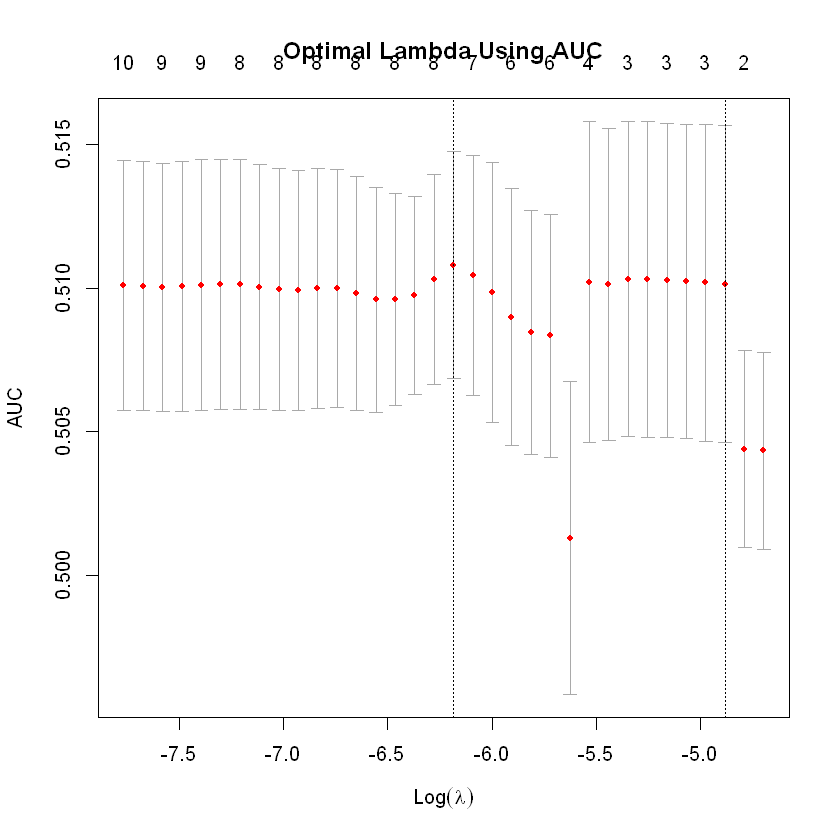

In [166]:
set.seed(9321)                                                    #setting the seed, randomly chosen
library(glmnet)    
cv_lasso <- cv.glmnet(train_X, train_Y, alpha = 1, family = "binomial", nfolds = 5, thresh = 1e-3, maxit = 1e3,type.measure = "auc")   #finding the best lambda for LASSO with CV
plot(cv_lasso, main = "Optimal Lambda Using AUC")                 #plot
print("Optimal Lambda")
cv_lasso$lambda.min                                               #optimal lambda

After performing the cross-validation, we can finally run the Lasso regression with the optimal $\lambda$.

In [167]:
                                                                    #running LASSO
lasso_model <- glmnet(train_X, train_Y, alpha = 1, family = "binomial",lambda = cv_lasso$lambda.min)
coef(cv_lasso, cv_lasso$lambda.min)                                 #coefficients kept in the model                                                                     

40 x 1 sparse Matrix of class "dgCMatrix"
                          s1
(Intercept)     3.216705e-02
ACTLCT          9.243861e-03
APSALE          1.735294e-03
CASHAT         -1.248508e-04
CASHMTA         .           
CHAT            .           
CHLCT           .           
EBIT+DP/AT      .           
EBITAT         -4.835384e-08
EBITSALE        3.310140e-09
EXCESSRETURN    .           
FAT             1.748299e-10
FFOLT           .           
INVCHINVT       1.490199e-13
INVTSALE        .           
(LCT-CH)/AT     .           
LCTAT           .           
LCTLT           .           
LCTSALE         .           
LT/(LT + MKET)  .           
LTAT            .           
LTMTA           .           
LOG(AT)         .           
LOG(SALE)       .           
MB              .           
MVEF            .           
NIAT            .           
NIMTA           .           
NISALE          .           
OIADPAT         .           
OIADPSALE       .           
PRICE           .           
Q

Together with the intercept, the table below shows us which coefficients are kept after using the variable selection technique. Among the 39 explanatory variables in the original dataset, $ACTLCT$, $APSALE$, $CASHAT$, $EBITAT$, $EBITSALE$, $FAT$ and $INVCHINVT$ are kept. These are the coefficients which are most significant in explaining the risk of default for the firms.

Note that in the original research work 7 variables were kept after applying the LASSO method. Given that I have artificial data, the values of the coefficients are not the same but the number of selected variables is identical. The results here also display 7 selected variables. According to the description of the variables, most of the selected ones are based on market data.

In [168]:
tmp_coeffs <- coef(cv_lasso, s = "lambda.min")
coeff_Lasso <- data.frame(name = tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1], 
                          coefficient = tmp_coeffs@x) 
coeff_Lasso

name,coefficient
<chr>,<dbl>
(Intercept),3.216705e-02
ACTLCT,9.243861e-03
APSALE,1.735294e-03
CASHAT,-1.248508e-04
EBITAT,-4.835384e-08
EBITSALE,3.310140e-09
FAT,1.748299e-10
INVCHINVT,1.490199e-13


Graphical representation of the selected coefficients.

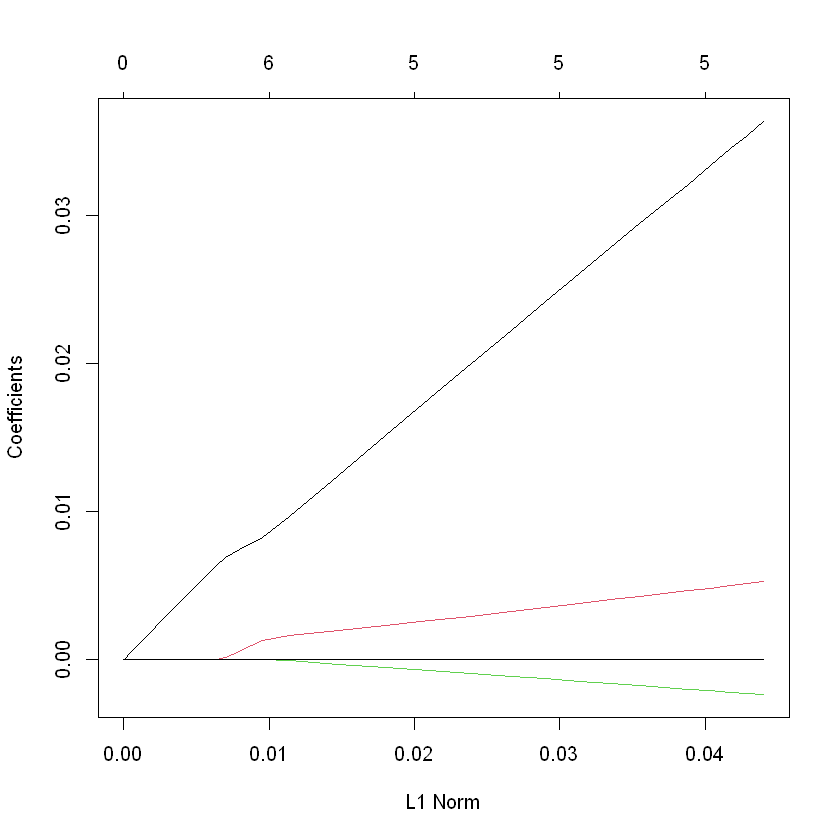

In [169]:
lasso.graph=glmnet(train_X,train_Y,family="binomial", alpha=1)        #comparison of the coefficients
plot(lasso.graph)                                                     #plot

In order to evaluate the performance of this model, here we can observe the performance measures. Compared to the logistic regression, all performance measures are in favor of this model. The Accuracy Rate, McFadden's Pseudo ${R}^2$ and AUC are all larger than in the previous setup. Additionally, the AIC is smaller which is a good indication since models with smaller AIC are more desirable. 

[1] "AICc"


[1] 6.62032

[1] "Accuracy Rate"


[1] 0.5044444

[1] "McFadden's Pseudo R^2"


[1] 0.0005405077

[1] "AUC"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5013  0.5098  0.5101  0.5094  0.5102  0.5108 

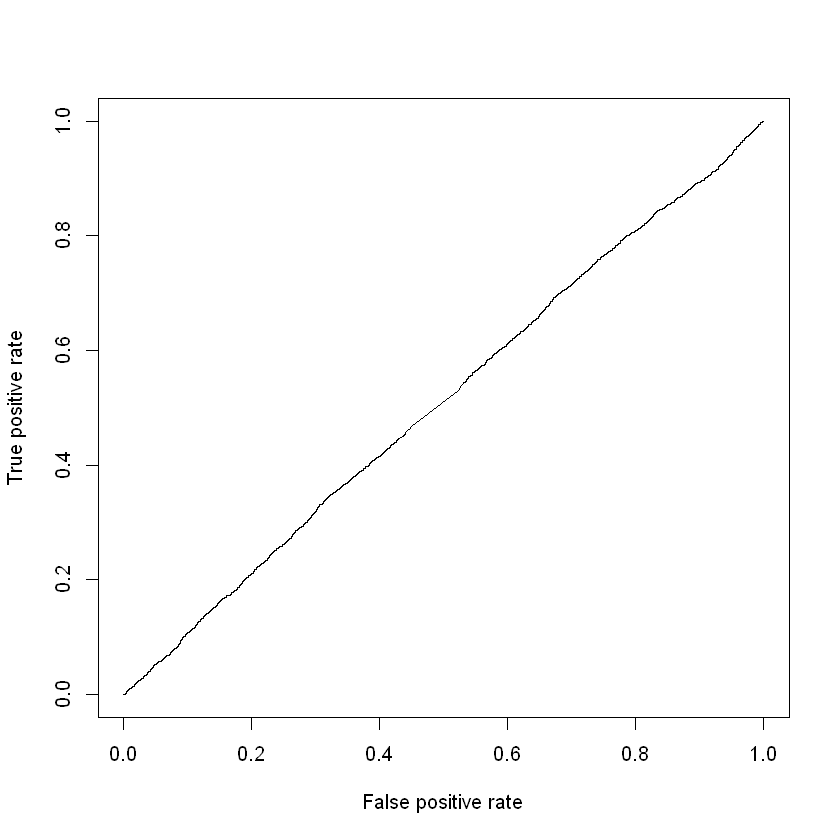

In [170]:
tLL <- lasso_model$nulldev - deviance(lasso_model)                #calculating AICc for Lasso
k <- lasso_model$df
c <- lasso_model$nobs
AICc <- -tLL+2*k+2*k*(k+1)/(c-k-1)
print("AICc")
AICc                                                              #checking AICc for Lasso, better model fitting

test <- model.matrix(BANKRUPTCY ~ ACTLCT + APSALE + CASHAT + CASHMTA + CHAT + CHLCT + `EBIT+DP/AT` + EBITAT + EBITSALE + EXCESSRETURN + FAT +
                    FFOLT + INVCHINVT + INVTSALE + `(LCT-CH)/AT` + LCTAT + LCTLT + LCTSALE +
                    `LT/(LT + MKET)` + LTAT + LTMTA +`LOG(AT)` + `LOG(SALE)` + MB + MVEF + NIAT +
                    NIMTA + NISALE + OIADPAT + OIADPSALE + PRICE + QALCT + REAT + RELCT + RSIZE +
                    SALEAT + SEQAT + SIGMA + WCAPAT ,test_data) [,-1]

probabilities <- lasso_model %>% predict(newx = test)             #checking how well does the model
predicted <- ifelse(probabilities > 0.5, "1", "0")                #perform on test data
observed <- test_data$BANKRUPTCY
ar_Lasso <-  mean(predicted == observed)                          #accuracy rate of the model on test data
print("Accuracy Rate")
ar_Lasso

R_sq_Lasso <- lasso_model$dev.ratio                               #McFadden’s Pseudo-R squared, on training data
print("McFadden's Pseudo R^2")
R_sq_Lasso
                
library(ROCR)                                                     #ROC curve with l1 regularized logistic regression
preds <- predict(cv_lasso, newx = train_X, type = 'response')
perf <- performance(prediction(preds, train_Y), 'tpr', 'fpr')
plot(perf)

AUC_Lasso <- max(cv_lasso$cvm)                                    #AUC for lasso

print("AUC")
summary(cv_lasso$cvm)      

#### CHS Model:

When considering the possibility of financial default in the reduced-form bankruptcy forecast model, researches in previous studies proposed numerous variables that could be of great importance for predicting this phenomenon. As mentioned, these variables are different from each other and are constructed based on both accounting and market data. Earlier studies, such as Beaver(1966), Altman(1968), Ohison(1980) and Zmijewski(1984) have used variables constructed only from accounting data. With the aim of improving this model, researchers in later periods suggested including other accounting and market-based variables. One of the most recent and important improvements was made by Campbell et all.(2008, CHS thereafter). In a similar fashion, they also incorporated new market-based and accounting variables and changed some of the already existing variables. 

In the CHS model the authors have considered $NIMTA$, $LTMTA$, $CASHMTA$, $RSIZE$, $PRICE$, $MB$, $SIGMA$ and $EXCESS RETURN$. They mainly advocate for incorporating market information in bankruptcy forecasts. That is, most of these variables are based on market information.

I run the logit regression for these variables and later report the performance measures.

In [171]:
                                                                #logit regression for CHS
logit_CHS <- glm(BANKRUPTCY ~ NIMTA + LTMTA + CASHMTA + RSIZE + PRICE + MB + SIGMA + EXCESSRETURN, 
                 family="binomial", data=train_data)

coeff_CHS <- coef(logit_CHS)                                    #storing the coefficients in a vector

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Compared with the LASSO model, the CHS model has a lower AUC statistic and accuracy rate. This is a good sign and we can argue that our LASSO model is better in predicting the outcome variable. At the very bottom of this chapter, I compare these statistics in more detail.

[1] "Min and Max value for AIC"


[1] 9981.497

[1] "McFadden's Pseudo R^2"


'log Lik.' 0.001115978 (df=9)

[1] "Brier Score"


[1] 1.249605

[1] "Accuracy Rate"


[1] 0.4944444

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train_data$BANKRUPTCY, predictor = logit_CHS$fitted.values,     percent = TRUE, plot = TRUE, legacy.axes = TRUE, xlab = "True Positive Rate",     ylab = "False Positive Rate", col = "#377eb8", lwd = 2, print.auc = TRUE)

Data: logit_CHS$fitted.values in 3531 controls (train_data$BANKRUPTCY 0) < 3666 cases (train_data$BANKRUPTCY 1).
Area under the curve: 50.59%

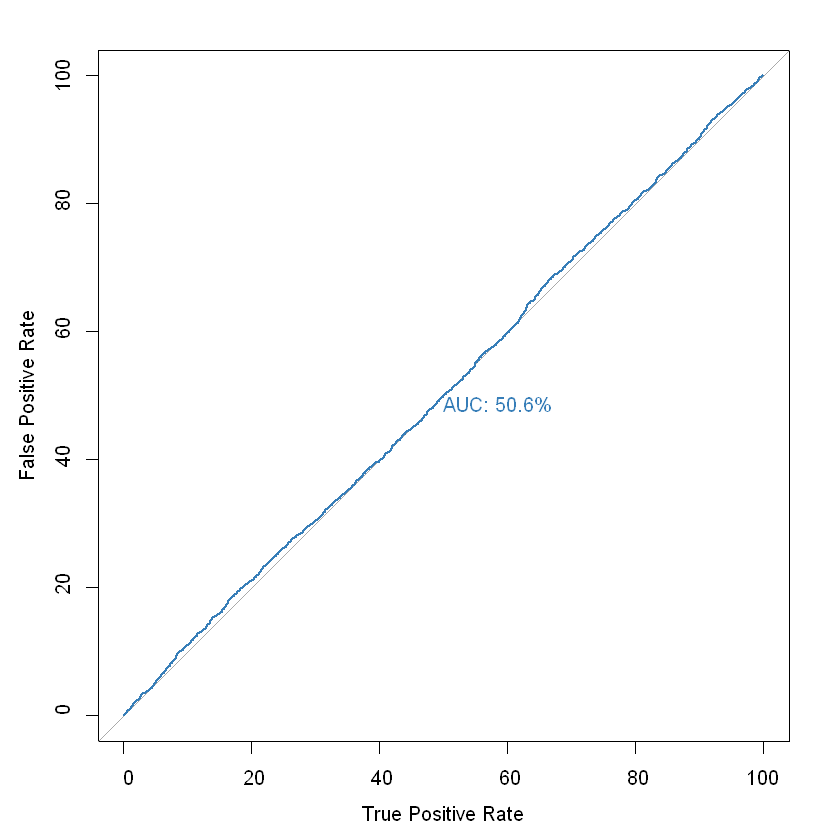

In [172]:
a1 <- summary(logit_CHS$aic)                                    #reporting AIC for CHS
AIC_CHS <- a1[6]
AIC_CHS <- unname(AIC_CHS)                                      #min and max
print("Min and Max value for AIC")
AIC_CHS

library(maxLik)                                                 #McFadden's Pseudo-R squared
R_sq_McFadden_CHS <- 1-logLik(logit_CHS)/logLik(null_model)
print("McFadden's Pseudo R^2")
R_sq_McFadden_CHS                                              

pred_prob_CHS <- predict(logit_CHS, type = 'response')
brierScore <- mean((pred_prob_CHS-train_Y_logit)^2)
print("Brier Score")
brierScore                                                      #Brier Score for CHS

probabilities_CHS <- logit_CHS %>% predict(test_data, type = "response")
predicted_classes_CHS <- ifelse(probabilities_CHS > 0.5, "1", "0")
ar_CHS <- mean(predicted_classes_CHS == test_data$BANKRUPTCY)   #Accuracy rate of the model
print("Accuracy Rate")
ar_CHS

library(pROC)                                                   #reporting AUC for CHS
roc(train_data$BANKRUPTCY, logit_CHS$fitted.values, plot = TRUE, legacy.axes = TRUE,
    percent = TRUE, xlab = "True Positive Rate",                #plotting ROC for CHS
    ylab = "False Positive Rate", col = "#377eb8", lwd = 2,
    print.auc = TRUE)

#### Comparison between Logistic Regression, LASSO and CHS Model:

In this sub-chapter, I compare the performance measures for the models we have seen above. Out of the three, the initial Logit regression which was fitted on all of the explanatory variables performs the worst. This was expected since there were a lot of variables included in this model. Some of the performance statistics for this model are: ${R}^2 = -24.97$, $AUC = 0.505$, $AIC = 259155$ and $Accuracy Rate = 0.481$.  

Secondly, the CHS model improves the performance of the initial logistic regression by using predetermined selected variables. We can see that the $Accuracy Rate = 0.494$, $R^2 = 0.001$ and $AUC = 0.506$ statistic are larger.  Also, the $AIC = 9981.49$ is smaller. Again, given the fact that this is artificial data, the results are not exactly the same as in the paper.

Finally, we can observe that the LASSO performs the best when it comes to model accuracy and variable selection. This advanced variable selection method makes the fit of the model better than the Logistic Regression and the CHS model. The $Accuracy Rate = 0.504$ and $AUC = 0.5108$ statistics are the highest and $AIC = 6.6203$, the lowest. This is consistent with the theory and the findings in the research paper this exercise is based on. First, it enables us to find the most relevant subset of variables among all of the bankruptcy predicting variables proposed in existing studies. "Such identification has important implication for testing bankruptcy theories, designing regulations in credit markets and conducting credit risk analysis". Secondly, this reduced form is much better in terms of prediction accuracy. "The selected reduced-form shows improved in-sample and out-of-sample performance when compared with the prominent models in the existing literature".

In [173]:
#Logistic Regression                                              #manually plugging the results from above
AUC <- 0.505                                                      #AUC
AIC_max <- "259155"                                               #max value for AIC
R_sq_McFadden <- (-24.9740)                                       #R^2
ar_logit <- 0.48111                                               #Accuracy Rate
Logit <- c(AUC, AIC_max, R_sq_McFadden, ar_logit)                 #combining them together

#LASSO Model          
AUC_Lasso <- 0.5108
AICc <- "6.6203"
ar_Lasso <- 0.5044
R_sq_Lasso <- "0.0005"

Lasso <- c(AUC_Lasso, AICc,R_sq_Lasso,ar_Lasso)                   #combining statistics for LASSO

#CHS model

AUC <- 0.506
AIC_CHS <- "9981.49"
R_sq_McFadden_CHS <- 0.0011
ar_CHS <- 0.4944

CHS <- c(AUC,AIC_CHS, R_sq_McFadden_CHS,ar_CHS)                   #combining statistics for CHS

Performance_Table <- cbind(Logit, Lasso, CHS)
Performance_Table <- as.data.frame(Performance_Table)
rownames(Performance_Table) <- c("AUC", "AIC", "McFadden Pseudo R^2", "Accuracy Rate") 
Performance_Table

,Logit,Lasso,CHS
,<chr>,<chr>,<chr>
AUC,0.505,0.5108,0.506
AIC,259155,6.6203,9981.49
McFadden Pseudo R^2,-24.974,0.0005,0.0011
Accuracy Rate,0.48111,0.5044,0.4944


In addition to the table above, we can also observe the difference between the LASSO and CHS model in more detail. Here, the values of the coefficients are combined together with the performance measurements. 

In [174]:
#Lasso
LassoModel <- c(coeff_Lasso[,2],AUC_Lasso, AICc,R_sq_Lasso,ar_Lasso) 

#CHS
#coeff_CHS
coeff_CHS1 <- c(0.02196543, 3.64776, -3.6009, 0.000629, 9.522196,-3.51779,2.7477,-5.9062,-3.38762)

CHSModel <- c(coeff_CHS1,AUC,AIC_CHS, R_sq_McFadden_CHS,ar_CHS)

#Lasso and CHS with coefficients

library(qpcR)
Comparison_Table <- qpcR:::cbind.na(LassoModel = c(3.2167,9.2438,1.7352,-1.2485,-4.8353,3.3101,1.7482,1.4901,"-",0.5108,
                                               6.6203, "0.0005", 0.5044), CHSModel = c(0.0219,3.6477,-3.6009, 0.0006,9.5221,-3.5177,
                                                2.7477,-5.9062,-3.3876,0.5060,9981.49,0.0011,0.4944))
                                               
rownames(Comparison_Table) <- c("intercept", "coeff1", "coeff2", "coeff3", "coeff4", "coeff5", "coeff6", "coeff7", "coeff8",
                               "AUC", "AIC", "McFadden R^2", "Accuracy Rate")
Comparison_Table

,LassoModel,CHSModel
intercept,3.2167,0.0219
coeff1,9.2438,3.6477
coeff2,1.7352,-3.6009
coeff3,-1.2485,6e-04
coeff4,-4.8353,9.5221
coeff5,3.3101,-3.5177
coeff6,1.7482,2.7477
coeff7,1.4901,-5.9062
coeff8,-,-3.3876
AUC,0.5108,0.506


### 3. Robustness Check :

#### Subsample for Train and Test Data in the period 1980-2002:

As a first robustness check, the authors took a subsample of the data in the period of 1980-2002. I repeat the same procedure with splitting the data as before but this time with the subsample of the period mentioned above. Afterwards, we run the LASSO regression and the CHS logistic model and compare the performance measures. We assume that the performance measures would stay similar to the results above. That is, we expect the LASSO sub-model to perform better than the CHS sub-model.

##### Data

In [175]:
#Splitting the Data

library(dplyr)

subsample_data <- renamed_data %>% filter(`Year/Period` < "2003/1")
#subsample_data                                                 #subsample data omitting the period 2003-2009
                                                                #note that there exists a lead for BANKRUPTCY from above
sample1 <- floor(0.80*nrow(subsample_data)) 
set.seed(124)                                                   #setting seed to make the partition reproducible
train_ind_sub <- sample(seq_len(nrow(subsample_data)), size = sample1)                                                               
subsample_train <- subsample_data[train_ind_sub,]               #train data for the subsample
subsample_train <- na.omit(subsample_train)                     #omitting NA variables

subsample_test  <- subsample_data[-train_ind_sub,]              #test data for subsample 1980-2002
subsample_test <- na.omit(subsample_test)                       #omitting NA variables

train_X_sub <- subsample_train[,4:42]                           #extracting X variables
train_X_sub <- as.matrix(train_X_sub)                           #converting into matrix form            
train_Y_sub <- subsample_train[,3]                              #extracting Y variable
train_Y_sub <- as.matrix(train_Y_sub)                           #converting into a matrix form

subsample_train
subsample_test

,FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,OIADPSALE,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5441,79,1999/2,0,-1.00788168,1.015825473,-1.023832e+00,1.031901e+00,-1.040035e+00,1.048232e+00,-1.056494e+00,...,1.265571e+00,-1.275546e+00,1.285599e+00,-1.295732e+00,1.305944e+00,-1.316237e+00,1.326612e+00,-1.337067e+00,1.347606e+00,-1.358227e+00
2215,33,1982/1,0,-0.18825661,0.035440550,-6.671918e-03,1.256033e-03,-2.364564e-04,4.451448e-05,-8.380146e-06,...,1.747860e-22,-3.290463e-23,6.194513e-24,-1.166158e-24,2.195370e-25,-4.132928e-26,7.780511e-27,-1.464733e-27,2.757456e-28,-5.191093e-29
1002,15,1991/3,0,0.66965849,0.448442491,3.003033e-01,2.011007e-01,1.346688e-01,9.018208e-02,6.039120e-02,...,5.964875e-06,3.994429e-06,2.674903e-06,1.791272e-06,1.199540e-06,8.032824e-07,5.379249e-07,3.602259e-07,2.412284e-07,1.615406e-07
1435,21,1998/1,0,0.28413042,0.080730095,2.293788e-02,6.517348e-03,1.851777e-03,5.261461e-04,1.494941e-04,...,4.032106e-17,1.145644e-17,3.255123e-18,9.248794e-19,2.627864e-19,7.466560e-20,2.121477e-20,6.027761e-21,1.712670e-21,4.866217e-22
6405,93,1998/3,0,0.62024681,0.384706101,2.386127e-01,1.479988e-01,9.179577e-02,5.693604e-02,3.531439e-02,...,5.983236e-07,3.711083e-07,2.301787e-07,1.427676e-07,8.855116e-08,5.492357e-08,3.406617e-08,2.112943e-08,1.310546e-08,8.128622e-09
2776,41,1985/1,0,-3.44328200,11.856190925,-4.082421e+01,1.405693e+02,-4.840196e+02,1.666616e+03,-5.738629e+03,...,1.285813e+16,-4.427416e+16,1.524484e+17,-5.249229e+17,1.807458e+18,-6.223586e+18,2.142956e+19,-7.378803e+19,2.540730e+20,-8.748450e+20
5510,80,1999/2,0,1.73686053,3.016684500,5.239560e+00,9.100385e+00,1.580610e+01,2.745299e+01,4.768202e+01,...,1.559367e+07,2.708403e+07,4.704119e+07,8.170398e+07,1.419084e+08,2.464751e+08,4.280929e+08,7.435377e+08,1.291421e+09,2.243019e+09
3146,46,1993/2,0,0.20179034,0.040719339,8.216769e-03,1.658065e-03,3.345814e-04,6.751530e-05,1.362393e-05,...,1.402849e-21,2.830813e-22,5.712307e-23,1.152688e-23,2.326014e-24,4.693671e-25,9.471375e-26,1.911232e-26,3.856681e-27,7.782410e-28
1953,29,1986/3,0,-0.05209134,0.002713508,-1.413503e-04,7.363126e-06,-3.835551e-07,1.997990e-08,-1.040780e-09,...,3.183954e-39,-1.658564e-40,8.639685e-42,-4.500528e-43,2.344385e-44,-1.221222e-45,6.361509e-47,-3.313795e-48,1.726201e-49,-8.992011e-51


,FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,OIADPSALE,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1980/1,0,0.07500664,0.005625996,0.000421987,3.165183e-05,2.374097e-06,1.780731e-07,1.335666e-08,...,1.790569e-34,1.343046e-35,1.007373e-36,7.555969e-38,5.667478e-39,4.250985e-40,3.188521e-41,2.391602e-42,1.793861e-43,1.345515e-44
5,1,1981/2,0,-1.50604329,2.268166398,-3.415956790,5.144579e+00,-7.747958e+00,1.166876e+01,-1.757366e+01,...,2.163335e+05,-3.258075e+05,4.906803e+05,-7.389857e+05,1.112945e+06,-1.676143e+06,2.524343e+06,-3.801770e+06,5.725631e+06,-8.623048e+06
6,1,1981/3,0,0.19272891,0.037144434,0.007158807,1.379709e-03,2.659098e-04,5.124851e-05,9.877070e-06,...,3.535137e-22,6.813231e-23,1.313107e-23,2.530736e-24,4.877460e-25,9.400277e-26,1.811705e-26,3.491680e-27,6.729476e-28,1.296965e-28
9,1,1982/3,0,1.83614286,3.371420619,6.190409913,1.136648e+01,2.087048e+01,3.832117e+01,7.036315e+01,...,8.264072e+07,1.517402e+08,2.786166e+08,5.115799e+08,9.393338e+08,1.724751e+09,3.166889e+09,5.814861e+09,1.067692e+10,1.960434e+10
10,1,1983/1,0,-0.66192262,0.438141553,-0.290015804,1.919680e-01,-1.270680e-01,8.410917e-02,-5.567376e-02,...,4.209366e-06,-2.786274e-06,1.844298e-06,-1.220783e-06,8.080636e-07,-5.348756e-07,3.540462e-07,-2.343512e-07,1.551224e-07,-1.026790e-07
11,1,1983/2,1,-1.58429794,2.509999965,-3.976587776,6.300100e+00,-9.981235e+00,1.581325e+01,-2.505290e+01,...,9.887938e+05,-1.566544e+06,2.481872e+06,-3.932025e+06,6.229500e+06,-9.869383e+06,1.563604e+07,-2.477215e+07,3.924647e+07,-6.217810e+07
24,1,1987/3,1,3.63267160,13.196302948,47.937834933,1.741424e+02,6.326022e+02,2.298036e+03,8.348010e+03,...,6.408910e+16,2.328146e+17,8.457391e+17,3.072293e+18,1.116063e+19,4.054290e+19,1.472791e+20,5.350164e+20,1.943539e+21,7.060239e+21
26,1,1988/2,1,0.31451138,0.098917407,0.031110650,9.784653e-03,3.077385e-03,9.678726e-04,3.044069e-04,...,8.493582e-16,2.671328e-16,8.401631e-17,2.642408e-17,8.310675e-18,2.613802e-18,8.220705e-19,2.585505e-19,8.131708e-20,2.557515e-20
27,1,1988/3,0,1.09728004,1.204023480,1.321150928,1.449673e+00,1.590697e+00,1.745440e+00,1.915236e+00,...,1.620035e+01,1.777632e+01,1.950560e+01,2.140310e+01,2.348520e+01,2.576984e+01,2.827673e+01,3.102749e+01,3.404585e+01,3.735783e+01


##### LASSO Model

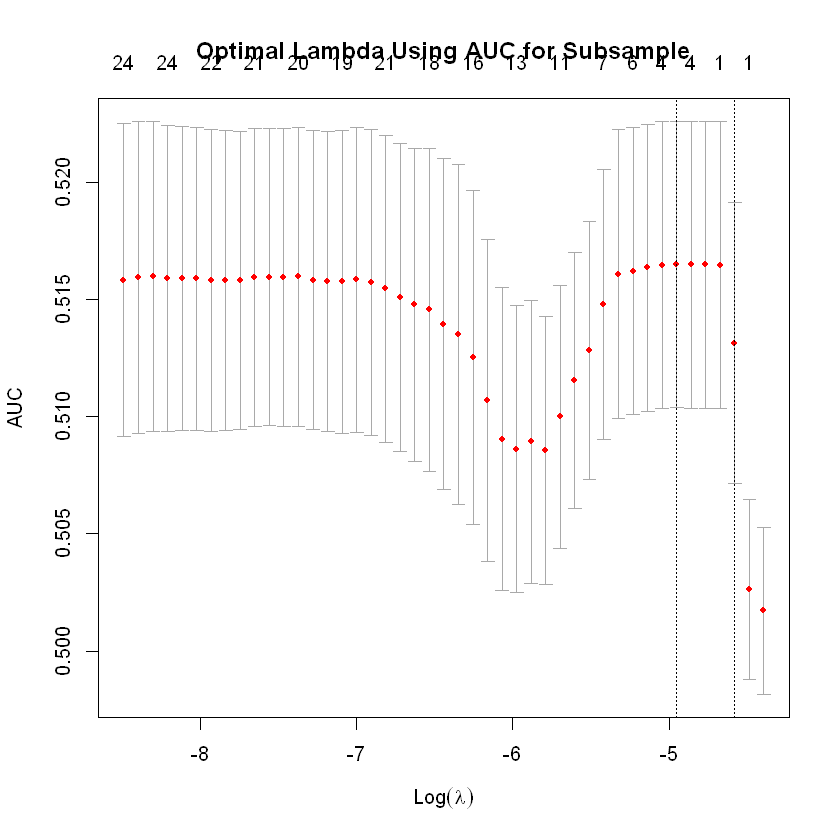

In [176]:
#LASSO Model

set.seed(9321)                                                      #setting the seed
cv_lasso_sub <- cv.glmnet(train_X_sub, train_Y_sub, alpha = 1, family = "binomial", nfolds = 10, thresh = 1e-3, maxit = 1e3,type.measure = "auc")   
plot(cv_lasso_sub, main = "Optimal Lambda Using AUC for Subsample") #finding optimal lambda according to auc

                                                                    #running the LASSO method
lasso_model_sub <- glmnet(train_X_sub, train_Y_sub, alpha = 1, family = "binomial",
                      lambda = cv_lasso_sub$lambda.min)

In [177]:
#Performance Measures

tLL_sub <- lasso_model_sub$nulldev - deviance(lasso_model_sub)  #calculating AICc for LASSO/Subsample
k_sub <- lasso_model_sub$df
c_sub <- lasso_model_sub$nobs
AICc_sub <- -tLL_sub+2*k_sub+2*k_sub*(k_sub+1)/(c_sub-k_sub-1) 
print("AICc Subsample")
AICc_sub                                                        #AICc for LASSO/Subsample

test_sub <- model.matrix(BANKRUPTCY ~ ACTLCT + APSALE + CASHAT + CASHMTA + CHAT + CHLCT + `EBIT+DP/AT` + EBITAT + EBITSALE + EXCESSRETURN + FAT +
                       FFOLT + INVCHINVT + INVTSALE + `(LCT-CH)/AT` + LCTAT + LCTLT + LCTSALE +
                       `LT/(LT + MKET)` + LTAT + LTMTA +`LOG(AT)` + `LOG(SALE)` + MB + MVEF + NIAT +
                       NIMTA + NISALE + OIADPAT + OIADPSALE + PRICE + QALCT + REAT + RELCT + RSIZE +
                       SALEAT + SEQAT + SIGMA + WCAPAT ,subsample_test) [,-1]


probabilities_sub <- lasso_model_sub %>% predict(newx = test_sub)
predicted_sub <- ifelse(probabilities_sub > 0.5, "1", "0")      
observed_sub <- subsample_test$BANKRUPTCY
ar_Lasso_sub <- mean(predicted_sub == observed_sub)             
print("Accuracy Rate Subsample")
ar_Lasso_sub                                                    #accuracy rate of LASSO/Subsample

R_sq_Lasso_sub <- lasso_model_sub$dev.ratio                     
print("McFadden's Pseudo R^2 Subsample")
R_sq_Lasso_sub                                                  #McFadden's Pseudo R^2 of LASSO/Subsample

AUC_Lasso_sub <- max(cv_lasso_sub$cvm)                          #AUC LASSO/Subsample
print("AUC Subsample")
AUC_Lasso_sub

[1] "AICc Subsample"


[1] 3.241265

[1] "Accuracy Rate Subsample"


[1] 0.5036232

[1] "McFadden's Pseudo R^2 Subsample"


[1] 0.0003610804

[1] "AUC Subsample"


[1] 0.5164924

##### CHS Model

In [178]:
#CHS Model

logit_CHS_sub <- glm(BANKRUPTCY ~ NIMTA + LTMTA + CASHMTA + RSIZE + PRICE + MB + SIGMA + EXCESSRETURN, 
                 family="binomial", data=subsample_train)       #running the logit for CHS/Subsample

coeff_CHS_sub <- coef(logit_CHS_sub)                            #coefficients for CHS/Subsample

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "AIC Subsample"


[1] 7660.193

[1] "McFadden's Pseudo R^2 Subsample"


'log Lik.' 0.001317165 (df=9)

[1] "Brier Score Subsample"


[1] 0.2496533

[1] "Accuracy Rate Subsample"


[1] 0.4884058

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = subsample_train$BANKRUPTCY, predictor = logit_CHS_sub$fitted.values,     percent = TRUE, plot = TRUE, legacy.axes = TRUE, xlab = "True Positive Rate",     ylab = "False Positive Rate", col = "#377eb8", lwd = 2, print.auc = TRUE)

Data: logit_CHS_sub$fitted.values in 2750 controls (subsample_train$BANKRUPTCY 0) < 2770 cases (subsample_train$BANKRUPTCY 1).
Area under the curve: 51.17%

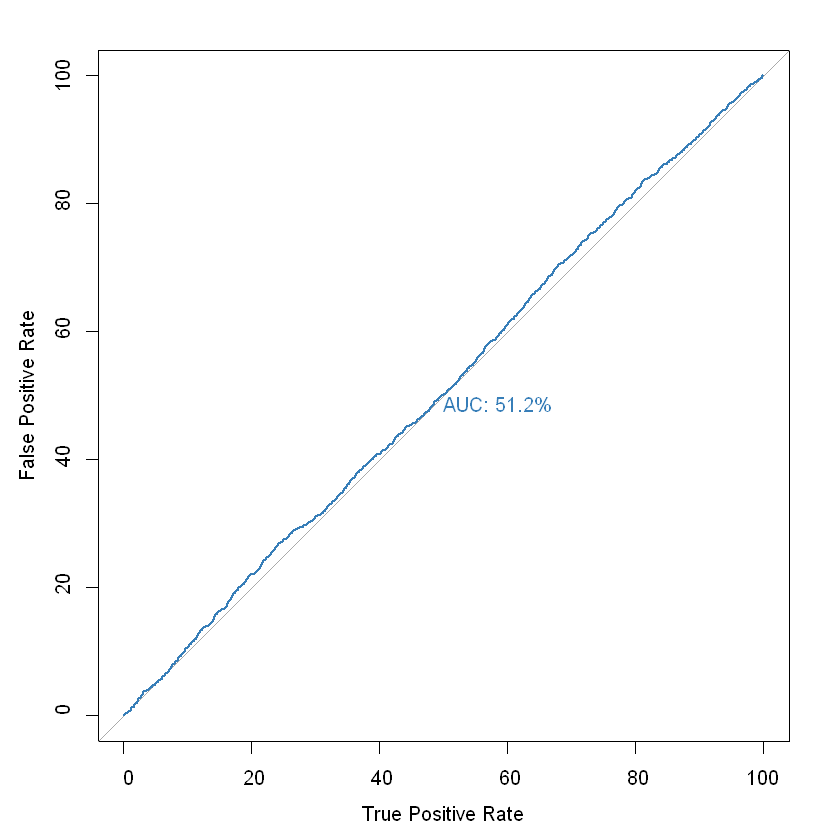

In [179]:
#Performance Measures

a1_sub <- summary(logit_CHS_sub$aic)                            #reporting AIC CHS/Subsample
AIC_CHS_sub <- a1_sub[6]
AIC_CHS_sub <- unname(AIC_CHS_sub)
print("AIC Subsample")
AIC_CHS_sub

null_model_sub <- glm(BANKRUPTCY ~ 1, family = "binomial", data = subsample_train)
R_sq_McFadden_CHS_sub <- 1-logLik(logit_CHS_sub)/logLik(null_model_sub)
print("McFadden's Pseudo R^2 Subsample")
R_sq_McFadden_CHS_sub                                           #McFadden's Pseudo R^2 CHS/Subsample


train_Y_sub <- as.numeric(subsample_train$BANKRUPTCY)           #converting back Y into numeric for Brier Score
pred_prob_sub <- predict(logit_CHS_sub, type = 'response')
brierScore_CHS_sub <- mean((pred_prob_sub-train_Y_sub)^2)
print("Brier Score Subsample")
brierScore_CHS_sub                                              #Brier Score for CHS/Subsample
                                                              
                                                                #accuracy rate CHS/Subsample
probabilities_CHS_sub <- logit_CHS_sub %>% predict(subsample_test, type = "response")
predicted_classes_CHS_sub <- ifelse(probabilities_CHS_sub > 0.5, "1", "0")
ar_CHS_sub <- mean(predicted_classes_CHS_sub == subsample_test$BANKRUPTCY)  
print("Accuracy Rate Subsample")
ar_CHS_sub

roc(subsample_train$BANKRUPTCY, logit_CHS_sub$fitted.values, plot = TRUE, legacy.axes = TRUE,
    percent = TRUE, xlab = "True Positive Rate",                #plotting ROC for CHS/Subsample
    ylab = "False Positive Rate", col = "#377eb8", lwd = 2,      
    print.auc = TRUE)                                           #AUC for CHS/Subsample

##### Comparison between LASSO,CHS,LASSO(1980-2002) and CHS(1980-2002):

After fitting the models on the subsample data, we can compare the LASSO and CHS model for both scenarios. In the table below, we can look at the performance statistics for the models fitted on the data for 1980-2009 period and for the sub-sample of 1980-2002 period. As expected, the performance measures stay in favor for the subsample LASSO model. Similarly to the comparison between the full sample models, LASSO subsample model performs better in terms of accuracy and variable selection. LASSO: $AUC = 0.516$, $Accuracy Rate = 0.503$ and $AIC = 3.24$, compared to CHS: $AUC = 0.512$, $Accuracy Rate = 0.488$ and $AIC = 7660.19$. The authors in the research paper find similar results. In their estimations, the LASSO model performs better than the CHS for both periods.

In [180]:
# LASSO

Lasso <- c(AUC_Lasso, AICc,R_sq_Lasso,ar_Lasso)

# CHS

CHS <- c(AUC,AIC_CHS, R_sq_McFadden_CHS,ar_CHS)

# LASSO(1980-2002)

#AUC_Lasso_sub
#AICc_sub
#R_sq_Lasso_sub
#ar_Lasso_sub

`Lasso(1980-2002)` <- c(AUC_Lasso_sub,AICc_sub,R_sq_Lasso_sub,ar_Lasso_sub)

# CHS(1980-2002)

AIC_CHS_sub <- '7660.193'
#R_sq_McFadden_CHS_sub
#ar_CHS_sub
AUC_CHS_sub <- 0.5117

`CHS(1980-2002)` <- c(AUC_CHS_sub, AIC_CHS_sub, R_sq_McFadden_CHS_sub, ar_CHS_sub)

Final_Table <- cbind(Lasso, CHS, `Lasso(1980-2002)` = c(0.512,3.2412,"0.0003",0.5036), `CHS(1980-2002)` = c(0.5117,7660.193,0.0013,0.4884))
rownames(Final_Table) <- c("AUC", "AIC", "McFadden Pseudo R^2", "Accuracy Rate")
Final_Table

,Lasso,CHS,Lasso(1980-2002),CHS(1980-2002)
AUC,0.5108,0.506,0.512,0.5117
AIC,6.6203,9981.49,3.2412,7660.193
McFadden Pseudo R^2,0.0005,0.0011,0.0003,0.0013
Accuracy Rate,0.5044,0.4944,0.5036,0.4884


#### Subsample for test data 2003-2009:

Additionally, in the second robustness check we can evaluate the performance of the LASSO and CHS models by splitting the bankruptcy data into a training sample ending in 2002 and a testing sample over the 2003-2009 period. We already have the training data for the period 1980-2002 from our first robustness check. We only have to perform a split in the data and extract the 2003-2009 test data.

In [181]:
#subsample train data for 1980-2002, from first robustness check

subsample_train

,FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,OIADPSALE,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5441,79,1999/2,0,-1.00788168,1.015825473,-1.023832e+00,1.031901e+00,-1.040035e+00,1.048232e+00,-1.056494e+00,...,1.265571e+00,-1.275546e+00,1.285599e+00,-1.295732e+00,1.305944e+00,-1.316237e+00,1.326612e+00,-1.337067e+00,1.347606e+00,-1.358227e+00
2215,33,1982/1,0,-0.18825661,0.035440550,-6.671918e-03,1.256033e-03,-2.364564e-04,4.451448e-05,-8.380146e-06,...,1.747860e-22,-3.290463e-23,6.194513e-24,-1.166158e-24,2.195370e-25,-4.132928e-26,7.780511e-27,-1.464733e-27,2.757456e-28,-5.191093e-29
1002,15,1991/3,0,0.66965849,0.448442491,3.003033e-01,2.011007e-01,1.346688e-01,9.018208e-02,6.039120e-02,...,5.964875e-06,3.994429e-06,2.674903e-06,1.791272e-06,1.199540e-06,8.032824e-07,5.379249e-07,3.602259e-07,2.412284e-07,1.615406e-07
1435,21,1998/1,0,0.28413042,0.080730095,2.293788e-02,6.517348e-03,1.851777e-03,5.261461e-04,1.494941e-04,...,4.032106e-17,1.145644e-17,3.255123e-18,9.248794e-19,2.627864e-19,7.466560e-20,2.121477e-20,6.027761e-21,1.712670e-21,4.866217e-22
6405,93,1998/3,0,0.62024681,0.384706101,2.386127e-01,1.479988e-01,9.179577e-02,5.693604e-02,3.531439e-02,...,5.983236e-07,3.711083e-07,2.301787e-07,1.427676e-07,8.855116e-08,5.492357e-08,3.406617e-08,2.112943e-08,1.310546e-08,8.128622e-09
2776,41,1985/1,0,-3.44328200,11.856190925,-4.082421e+01,1.405693e+02,-4.840196e+02,1.666616e+03,-5.738629e+03,...,1.285813e+16,-4.427416e+16,1.524484e+17,-5.249229e+17,1.807458e+18,-6.223586e+18,2.142956e+19,-7.378803e+19,2.540730e+20,-8.748450e+20
5510,80,1999/2,0,1.73686053,3.016684500,5.239560e+00,9.100385e+00,1.580610e+01,2.745299e+01,4.768202e+01,...,1.559367e+07,2.708403e+07,4.704119e+07,8.170398e+07,1.419084e+08,2.464751e+08,4.280929e+08,7.435377e+08,1.291421e+09,2.243019e+09
3146,46,1993/2,0,0.20179034,0.040719339,8.216769e-03,1.658065e-03,3.345814e-04,6.751530e-05,1.362393e-05,...,1.402849e-21,2.830813e-22,5.712307e-23,1.152688e-23,2.326014e-24,4.693671e-25,9.471375e-26,1.911232e-26,3.856681e-27,7.782410e-28
1953,29,1986/3,0,-0.05209134,0.002713508,-1.413503e-04,7.363126e-06,-3.835551e-07,1.997990e-08,-1.040780e-09,...,3.183954e-39,-1.658564e-40,8.639685e-42,-4.500528e-43,2.344385e-44,-1.221222e-45,6.361509e-47,-3.313795e-48,1.726201e-49,-8.992011e-51


In [182]:
#subsample test data for 2003-2009

set.seed(123)                                                        #setting theeed
subsample_data1 <- renamed_data %>% filter(`Year/Period` > "2003/1") #extracting data for 2003-2009 period
sample2 <- floor(0.80*nrow(subsample_data1))

set.seed(126)                                                        #setting seed to make the partition reproducible
test_ind_sub1 <- sample(seq_len(nrow(subsample_data1)), size = sample2)

subsample_test1  <- subsample_data1[-test_ind_sub1,]                 #test data for 2003-2009 period
subsample_test1 <- na.omit(subsample_test1)
subsample_test1

,FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,OIADPSALE,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
24,2,2004/2,1,-0.93547789,8.751189e-01,-8.186544e-01,7.658330e-01,-7.164199e-01,6.701950e-01,-6.269526e-01,...,1.352090e-01,-1.264851e-01,1.183240e-01,-1.106895e-01,1.035476e-01,-9.686645e-02,9.061642e-02,-8.476966e-02,7.930014e-02,-7.418353e-02
32,2,2007/1,0,3.37846936,1.141406e+01,3.856204e+01,1.302807e+02,4.401492e+02,1.487031e+03,5.023887e+03,...,7.271090e+15,2.456515e+16,8.299262e+16,2.803880e+17,9.472824e+17,3.200365e+18,1.081233e+19,3.652914e+19,1.234126e+20,4.169456e+20
33,2,2007/2,1,3.72242222,1.385643e+01,5.157947e+01,1.920006e+02,7.147072e+02,2.660442e+03,9.903288e+03,...,1.332812e+17,4.961290e+17,1.846801e+18,6.874575e+18,2.559007e+19,9.525705e+19,3.545869e+20,1.319922e+21,4.913308e+21,1.828941e+22
35,2,2008/1,0,-0.21718937,4.717122e-02,-1.024509e-02,2.225124e-03,-4.832733e-04,1.049618e-04,-2.279659e-05,...,1.273963e-20,-2.766912e-21,6.009438e-22,-1.305186e-22,2.834725e-23,-6.156722e-24,1.337175e-24,-2.904201e-25,6.307616e-26,-1.369947e-26
37,2,2008/3,1,-2.75237529,7.575570e+00,-2.085081e+01,5.738926e+01,-1.579568e+02,4.347563e+02,-1.196613e+03,...,1.553208e+13,-4.275010e+13,1.176643e+14,-3.238564e+14,8.913743e+14,-2.453397e+15,6.752668e+15,-1.858588e+16,5.115531e+16,-1.407986e+17
40,2,2009/3,0,-3.52486314,1.242466e+01,-4.379523e+01,1.543722e+02,-5.441408e+02,1.918022e+03,-6.760765e+03,...,2.595779e+16,-9.149767e+16,3.225168e+17,-1.136827e+18,4.007161e+18,-1.412470e+19,4.978762e+19,-1.754945e+20,6.185942e+20,-2.180460e+21
41,3,2003/2,1,-4.53899948,2.060252e+01,-9.351481e+01,4.244637e+02,-1.926640e+03,8.745020e+03,-3.969364e+04,...,5.114510e+19,-2.321476e+20,1.053718e+21,-4.782824e+21,2.170924e+22,-9.853821e+22,4.472649e+23,-2.030135e+24,9.214782e+24,-4.182589e+25
45,3,2004/3,1,0.35098328,1.231893e-01,4.323737e-02,1.517559e-02,5.326380e-03,1.869470e-03,6.561528e-04,...,2.283456e-14,8.014550e-15,2.812973e-15,9.873064e-16,3.465281e-16,1.216256e-16,4.268853e-17,1.498296e-17,5.258769e-18,1.845740e-18
49,3,2006/1,1,2.10544950,4.432918e+00,9.333284e+00,1.965076e+01,4.137368e+01,8.711019e+01,1.834061e+02,...,5.015854e+09,1.056063e+10,2.223487e+10,4.681439e+10,9.856533e+10,2.075243e+11,4.369320e+11,9.199383e+11,1.936884e+12,4.078011e+12


In the next steps, we focus only on the Accuracy Rate. We first compute the Accuracy Rate and compare this statistic between the models. In the first robustness check, we already fitted the models on the 1980-2002 train data. Therefore, we use these models and test how well they perform on the newly created test data for the period 2003-2009.

##### LASSO Model

In [183]:
#LASSO Model

test_sub1 <- model.matrix(BANKRUPTCY ~ ACTLCT + APSALE + CASHAT + CASHMTA + CHAT + CHLCT + `EBIT+DP/AT` + 
                          EBITAT + EBITSALE + EXCESSRETURN + FAT + FFOLT + INVCHINVT + INVTSALE + `(LCT-CH)/AT` + LCTAT + 
                          LCTLT + LCTSALE + `LT/(LT + MKET)` + LTAT + LTMTA +`LOG(AT)` + `LOG(SALE)` + MB + MVEF + NIAT +
                          NIMTA + NISALE + OIADPAT + OIADPSALE + PRICE + QALCT + REAT + RELCT + RSIZE +
                          SALEAT + SEQAT + SIGMA + WCAPAT ,subsample_test1) [,-1]


probabilities_sub1 <- lasso_model_sub %>% predict(newx = test_sub1) #performance on subsample test data
predicted_sub1 <- ifelse(probabilities_sub1 > 0.5, "1", "0")      
observed_sub1 <- subsample_test1$BANKRUPTCY
ar_Lasso_sub1 <- mean(predicted_sub1 == observed_sub1)              #accuracy rate of the model on subsample test data
print("Accuracy Rate Test Data Subsample")
ar_Lasso_sub1                                                       #reporting accuracy rate on test data for 2003-2009 period

[1] "Accuracy Rate Test Data Subsample"


[1] 0.4775

##### CHS Model

In [184]:
# CHS Model

probabilities_CHS_sub1 <- logit_CHS_sub %>% predict(subsample_test1, type = "response")
predicted_classes_CHS_sub1 <- ifelse(probabilities_CHS_sub1 > 0.5, "1", "0")
ar_CHS_sub1 <- mean(predicted_classes_CHS_sub1 == subsample_test1$BANKRUPTCY)  
print("Accuracy Rate Test Data Subsample")
ar_CHS_sub1

[1] "Accuracy Rate Test Data Subsample"


[1] 0.4725

##### Comparison between Accuracy Rates for LASSO and CHS

We can observe from the table that the results stay the same. The Accuracy Rate is still higher for the Lasso Model. $Accuracy Rate-Lasso = 0.4775$ and $Accuracy Rate-CHS = 0.4725$.

In [185]:
Accuracy_Table <- cbind(ar_Lasso_sub1, ar_CHS_sub1)
Accuracy_Table <- as.data.frame(Accuracy_Table)
rownames(Accuracy_Table) <- c("Accuracy Rate Test Data Subsample")
Accuracy_Table <- dplyr::rename(Accuracy_Table,`Lasso Model` = ar_Lasso_sub1, `CHS Model` = ar_CHS_sub1)
Accuracy_Table

,Lasso Model,CHS Model
,<dbl>,<dbl>
Accuracy Rate Test Data Subsample,0.4775,0.4725


### 4. Simulation Study:

In this chapter, we perform a small simulation study. Our main goal is to see how does the performance measures of the variable selection technique behave as we introduce changes in the data. We adjust the data by increasing the number of covariates. Given the fact that there are a lot of other existing variables used in finance and bankruptcy forecasting scenarios, this increase of covariates is realistic. The authors in the paper added another variable to the specified 39 bankruptcy predicting variables and observed whether this variable was selected by the LASSO. Since we don't have the original dataset, I cannot perform the same test as they did and see whether the new variable DD would be selected. However, using the performance statistics I can conduct other tests and see how they change. The main performance measures used in these tests is the "Accuracy Rate" of the model. This statistic measures how many classifications of BANKRUPTCY were correctly predicted. The higher the rate is, the better the model performs with the variables included. In total, we perform two tests on the modified data generating process.

First of all, we can take a look at different time horizons for predicting bankruptcy with the additional DD variable. As I stated above, the most used time horizon in predicting bankruptcy is one year in the future. That is, when we fit the model, we assume that the main outcome variable is taken one year ahead. Foreseeing the default risk at different horizons is of great interest to practitioners and researchers. Thus, we run the model on an outcome variable at period t, period t+12 and period t+24. Then, we compare how does the Accuracy Rate and AUC statistic behave. In the paper, when the authors did this on the original data set, the Accuracy Rate and AUC declined as they further increased the time horizons. We expect to see similar results here. 

In the second part of the simulation study, we increase the number of covariates in the data to 50. We again use the Lasso technique to select the most significant coefficients and see how do the performance measures compare with the model we already fitted in the previous setup. Again, we use the optimal prediction time horizon of one year. Additionally, we report other statistics, AIC and AUC. We would expect that these statistics improve because we have more variables specified in the data. In addition, we also compare the LASSO and CHS model for this data generating process.

We first proceed with the data generating process. One difference in the initial setup here is that we also winsorize the variables. In order to minimize the effects of outliers in the next steps, I decide to limit the extreme values of the explanatory variables at the 1st and 99th percentile. 

In [186]:
#Data Generationg Process for Simulation Study

set.seed(123)
n_sim <- 9000                       #number of observations, stays the same as the original
p_sim <- 40                         #we use one additional parameter, as suggested in the paper
beta_sim <- runif(p_sim,-5,5)       #true beta coefficients, uniformly distributed

DataGeneratingProcess_sim <- function(N, P, Beta, Mu, Sig){
  eps <- rnorm(n_sim,mean=0, sd= 5) #normally distributed error term, with sd=5
  mu <- rep(Mu,p_sim)
  sig <- diag(Sig^2, p_sim, p_sim)
  X <- cbind(poly(rnorm(n_sim, 0, sqrt(4)),p_sim, raw = TRUE))
  z = X %*% beta_sim + eps          #linear combination with a bias
  pr = 1/(1+exp(-z))                #pass through an inv-logit function
  Y = rbinom(9000,1,pr)             #creating a binary outcome variable, bankruptcy
  data <- data.frame("Y"=Y, "X"=X)
  return(data)
}

library(MASS)                       #storing the data
data_sim <- DataGeneratingProcess_sim(N = n_sim, P = p_sim, Beta = beta_sim, Mu = 0, Sig = 1)

                                    #we can comment this out since we have it saved already
#Firmid <- c(1:100)                 #creating panel variables
#year <- c("1980/1", "1980/2", "1980/3", "1981/1","1981/2","1981/3", "1982/1", "1982/2", "1982/3", "1983/1", "1983/2",
          #"1983/3", "1984/1", "1984/2", "1984/3", "1985/1", "1985/2", "1985/3", "1986/1", "1986/2", "1986/3","1987/1",
          #"1987/2" ,"1987/3","1988/1","1988/2","1988/3","1989/1","1989/2","1989/3","1990/1","1990/2","1990/3","1991/1",
          #"1991/2","1991/3","1992/1","1992/2","1992/3","1993/1","1993/2","1993/3","1994/1","1994/2","1994/3","1995/1",
          #"1995/2","1995/3","1996/1","1996/2","1996/3","1997/1","1997/2","1997/3","1998/1","1998/2","1998/3","1999/1","1999/2","1999/3","2000/1",
          #"2000/2","2000/3","2001/1","2001/2","2001/3","2002/1","2002/2","2002/3","2003/1","2003/2","2003/3","2004/1","2004/2","2004/3",
          #"2005/1","2005/2","2005/3","2006/1","2006/2","2006/3","2007/1","2007/2","2007/3","2008/1","2008/2","2008/3",
          #"2009/1","2009/2","2009/3")

paneldata_sim <- merge(Firmid, year)#merging them together

library(data.table)                 #sorting the panel variables
dt <- data.table(paneldata_sim, key = 'x')
sorted_sim <- dt[, list(Y = sort(y)), by = 'x']

                                    #framing all of the variables
moddata_sim <- data.frame(sorted_sim,data_sim) 


library(tidyverse)                  #renaming the variables, we have additional variable named DD
renamed_data_sim <- dplyr::rename(moddata_sim,FirmID = x, `Year/Period` = Y, BANKRUPTCY = Y.1, ACTLCT = X.1,APSALE = X.2, CASHAT = X.3, CASHMTA = X.4, CHAT = X.5, CHLCT =X.6, 
                              `EBIT+DP/AT` = X.7, EBITAT = X.8, EBITSALE = X.9, EXCESSRETURN = X.10, FAT = X.11,
                               FFOLT = X.12, INVCHINVT = X.13, INVTSALE = X.14, `(LCT-CH)/AT` = X.15, LCTAT = X.16,
                               LCTLT = X.17, LCTSALE = X.18, `LT/(LT + MKET)` = X.19, LTAT = X.20, LTMTA = X.21,
                              "LOG(AT)" = X.22, `LOG(SALE)` = X.23, MB = X.24, MVEF = X.25, NIAT = X.26, NIMTA = X.27,
                               NISALE = X.28, OIADPAT = X.29, OIADPSALE = X.30, PRICE = X.31, QALCT = X.32,
                               REAT = X.33, RELCT = X.34, RSIZE = X.35, SALEAT = X.36, SEQAT = X.37, SIGMA = X.38,
                               WCAPAT = X.39, DD = X.40)

In [187]:
#WINSORIZING PROCESS

library(DescTools)                  
library(magrittr)
library(dplyr)
                                     #defining variables for the winsorizing process
winz_var <- c("ACTLCT", "APSALE", "CASHAT", "CASHMTA", "CHAT", "CHLCT", "EBIT+DP/AT", "EBITAT", "EBITSALE", "EXCESSRETURN", "FAT",
              "FFOLT", "INVCHINVT", "INVTSALE", "(LCT-CH)/AT", "LCTAT", "LCTLT", "LCTSALE", "LT/(LT + MKET)", "LTAT", "LTMTA",
              "LOG(AT)", "LOG(SALE)", "MB", "MVEF", "NIAT", "NIMTA","NISALE", "OIADPAT", "OIADPSALE", "PRICE", "QALCT",
              "REAT", "RELCT", "RSIZE", "SALEAT", "SEQAT", "SIGMA", "WCAPAT","DD")

setDT(renamed_data_sim)              #replacing the extreme values at 1% and 99%
renamed_data_sim <- renamed_data_sim %>% 
  .[,(winz_var) := lapply(.SD,Winsorize,probs= c(0.01,0.99), na.rm = TRUE, type = 1),
  .SDcols = winz_var]

#### Simulation Study N.1:

In [188]:
#Splitting the data without any leads for bankruptcy

sample_sim <- floor(0.80*nrow(renamed_data_sim)) 
set.seed(124)                                                   #setting seed to make the partition reproducible
train_ind_sim <- sample(seq_len(nrow(renamed_data_sim)), size = sample_sim)

train_data_sim <- renamed_data_sim[train_ind_sim,]              #train data
train_data_sim <- na.omit(train_data_sim)                       #omitting NA variables

test_data_sim  <- renamed_data_sim[-train_ind_sim,]             #test data
test_data_sim <- na.omit(test_data_sim)                         #omitting NA variables

train_X_lead <- train_data_sim[,4:43]                           #extracting X covariates with the added DD variable
train_X_lead <- as.matrix(train_X_lead)                         #converting into matrix form            

train_data_sim                                                  #train data for simulation study N.1
test_data_sim                                                   #test data for simulation study N.1

FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT,DD
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,1993/2,0,1.17291498,1.375730e+00,1.613614e+00,1.892632e+00,2.219896e+00,2.603749e+00,3.053977e+00,...,1.403662e+02,1.646376e+02,1.931059e+02,2.264968e+02,2.656615e+02,3.115983e+02,3.654784e+02,4.286750e+02,5.027994e+02,5.897409e+02
12,1983/3,0,4.18657532,1.752741e+01,7.337983e+01,3.072102e+02,1.286159e+03,5.384600e+03,2.254303e+04,...,1.895074e+19,7.933870e+19,3.321574e+20,1.390602e+21,5.821861e+21,2.437366e+22,1.020422e+23,4.272072e+23,1.788535e+24,7.487836e+24
31,2005/1,1,0.96818919,9.373903e-01,9.075712e-01,8.787006e-01,8.507484e-01,8.236854e-01,7.974833e-01,...,3.670854e-01,3.554081e-01,3.441023e-01,3.331561e-01,3.225581e-01,3.122973e-01,3.023629e-01,2.927444e-01,2.834320e-01,2.744158e-01
62,1986/2,0,3.61248777,1.305007e+01,4.714321e+01,1.703043e+02,6.152221e+02,2.222482e+03,8.028690e+03,...,1.958835e+17,7.076269e+17,2.556294e+18,9.234579e+18,3.335981e+19,1.205119e+20,4.353477e+20,1.572688e+21,5.681317e+21,2.052369e+22
22,2000/3,0,1.47594244,2.178406e+00,3.215202e+00,4.745453e+00,7.004015e+00,1.033752e+01,1.525759e+01,...,1.742417e+05,2.571707e+05,3.795691e+05,5.602221e+05,8.268556e+05,1.220391e+06,1.801227e+06,2.658508e+06,3.923805e+06,5.791310e+06
16,2004/1,1,-0.38528867,1.484474e-01,-5.719509e-02,2.203662e-02,-8.490460e-03,3.271278e-03,-1.260386e-03,...,-1.443356e-13,5.561087e-14,-2.142624e-14,8.255286e-15,-3.180668e-15,1.225475e-15,-4.721618e-16,1.819186e-16,-7.009118e-17,2.700534e-17
78,2004/1,0,1.93897430,3.759621e+00,7.289809e+00,1.413475e+01,2.740692e+01,5.314132e+01,1.030396e+02,...,8.217385e+08,1.593330e+09,3.089426e+09,5.990317e+09,1.161507e+10,2.252132e+10,4.366827e+10,8.467165e+10,1.641762e+11,3.183334e+11
6,2007/1,0,-0.15617452,2.439048e-02,-3.809172e-03,5.948956e-04,-9.290754e-05,1.450979e-05,-2.266060e-06,...,-1.004421e-25,1.568650e-26,-2.449832e-27,3.826013e-28,-5.975258e-29,9.331831e-30,-1.457394e-30,2.276078e-31,-3.554655e-32,5.551465e-33
74,1981/1,0,-1.23996713,1.537518e+00,-1.906472e+00,2.363963e+00,-2.931237e+00,3.634637e+00,-4.506830e+00,...,-7.865301e+02,9.752715e+02,-1.209305e+03,1.499498e+03,-1.859328e+03,2.305506e+03,-2.858752e+03,3.544758e+03,-4.395383e+03,5.450131e+03


FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT,DD
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980/1,0,-0.85559802,7.320480e-01,-6.263388e-01,5.358942e-01,-4.585100e-01,3.923003e-01,-3.356513e-01,...,-7.949922e-03,6.801937e-03,-5.819724e-03,4.979344e-03,-4.260317e-03,3.645119e-03,-3.118756e-03,2.668402e-03,-2.283079e-03,1.953398e-03
1,1981/1,0,1.77183297,3.139392e+00,5.562478e+00,9.855783e+00,1.746280e+01,3.094117e+01,5.482258e+01,...,5.024654e+07,8.902847e+07,1.577436e+08,2.794953e+08,4.952190e+08,8.774453e+08,1.554686e+09,2.754645e+09,4.880770e+09,8.647910e+09
1,1981/2,0,3.67540303,1.350859e+01,4.964950e+01,1.824819e+02,6.706947e+02,2.465073e+03,9.060137e+03,...,3.345446e+17,1.229586e+18,4.519225e+18,1.660997e+19,6.104835e+19,2.243773e+20,8.246769e+20,3.031020e+21,1.114022e+22,4.094480e+22
1,1988/3,0,-1.90162923,3.616194e+00,-6.876660e+00,1.307686e+01,-2.486733e+01,4.728845e+01,-8.992509e+01,...,-4.496775e+08,8.551199e+08,-1.626121e+09,3.092279e+09,-5.880368e+09,1.118228e+10,-2.126455e+10,4.043729e+10,-7.689673e+10,1.462291e+11
1,1989/1,0,0.52825780,2.790563e-01,1.474137e-01,7.787242e-02,4.113672e-02,2.173079e-02,1.147946e-02,...,2.559903e-09,1.352289e-09,7.143572e-10,3.773648e-10,1.993459e-10,1.053060e-10,5.562872e-11,2.938631e-11,1.552355e-11,8.200435e-12
1,1991/3,1,-1.01730295,1.034905e+00,-1.052812e+00,1.071029e+00,-1.089561e+00,1.108414e+00,-1.127592e+00,...,-1.702000e+00,1.731449e+00,-1.761408e+00,1.791886e+00,-1.822891e+00,1.854432e+00,-1.886519e+00,1.919162e+00,-1.952369e+00,1.986151e+00
1,1992/1,0,-0.22262012,4.955972e-02,-1.103299e-02,2.456166e-03,-5.467919e-04,1.217269e-04,-2.709885e-05,...,-5.949722e-21,1.324528e-21,-2.948665e-22,6.564322e-23,-1.461350e-23,3.253259e-24,-7.242410e-25,1.612306e-25,-3.589318e-26,7.990544e-27
1,1996/2,0,1.35784989,1.843756e+00,2.503544e+00,3.399437e+00,4.615926e+00,6.267734e+00,8.510642e+00,...,1.313423e+04,1.783431e+04,2.421632e+04,3.288212e+04,4.464899e+04,6.062662e+04,8.232185e+04,1.117807e+05,1.517814e+05,2.060964e+05
1,1999/1,0,-2.51978772,6.349330e+00,-1.599896e+01,4.031399e+01,-1.015827e+02,2.559669e+02,-6.449821e+02,...,-2.768743e+12,6.976644e+12,-1.757966e+13,4.429702e+13,-1.116191e+14,2.812564e+14,-7.087064e+14,1.785790e+15,-4.499811e+15,1.133857e+16


In [189]:
#LASSO without leads

train_Y_wlead <- train_data_sim[,3]                              #extracting Y variable without lead
train_Y_wlead <- as.matrix(train_Y_wlead)                        #matrix form

set.seed(129)
cv_lasso_wlead <- cv.glmnet(train_X_lead, train_Y_wlead, alpha = 1, family = "binomial", nfolds = 10,  thresh = 1e-3, maxit = 1e3, type.measure = "auc")
#cv_lasso_wlead$lambda.min                                       #optimal lambda, manually plugged in this setup, 10 fold cross-validation
lasso_model_wlead <- glmnet(train_X_lead, train_Y_wlead, alpha = 1, family = "binomial",lambda = 1.75)

                                                                 #ACCURACY RATE
test_wlead <- model.matrix(BANKRUPTCY ~ ACTLCT + APSALE + CASHAT + CASHMTA + CHAT + CHLCT + `EBIT+DP/AT` + EBITAT + EBITSALE + EXCESSRETURN + FAT +
                       FFOLT + INVCHINVT + INVTSALE + `(LCT-CH)/AT` + LCTAT + LCTLT + LCTSALE +
                       `LT/(LT + MKET)` + LTAT + LTMTA +`LOG(AT)` + `LOG(SALE)` + MB + MVEF + NIAT +
                       NIMTA + NISALE + OIADPAT + OIADPSALE + PRICE + QALCT + REAT + RELCT + RSIZE +
                       SALEAT + SEQAT + SIGMA + WCAPAT + DD ,test_data_sim) [,-1]

                                                                  #checking how well does the model on test data
probabilities_wlead <- lasso_model_wlead %>% predict(newx = test_wlead) 
predicted_wlead <- ifelse(probabilities_wlead > 0.5, "1", "0")    #perform on test data
observed_wlead <- test_data_sim$BANKRUPTCY
ar_Lasso_wlead <-  mean(predicted_wlead == observed_wlead)
print("Accuracy Rate Without Lead")
ar_Lasso_wlead                                                    #accuracy rate for model without lead

AUC_Lasso_wlead <- max(cv_lasso_wlead$cvm)
print("AUC Without Lead")
AUC_Lasso_wlead                                                   #AUC for model without lead

[1] "Accuracy Rate Without Lead"


[1] 0.7333333

[1] "AUC Without Lead"


[1] 0.8633768

In [190]:
#Splitting the data with a lead for BANKRUPTCY for four years

renamed_data_sim$BANKRUPTCY <- lead(renamed_data_sim$BANKRUPTCY, 12)     #creating a lead for BANKRUPTCY for four years 

set.seed(124)
sample_lead1 <- floor(0.80*nrow(renamed_data_sim)) 
train_ind_lead1 <- sample(seq_len(nrow(renamed_data_sim)), size = sample_lead1)

train_data_lead1 <- renamed_data_sim[train_ind_lead1,]                   #train data
train_data_lead1 <- na.omit(train_data_lead1)                            #omitting NA variables

test_data_lead1  <- renamed_data_sim[-train_ind_lead1,]                  #test data
test_data_lead1 <- na.omit(test_data_lead1)                              #omitting NA variables

train_data_lead1                                                         #overview of train data with four year lead
test_data_lead1                                                          #overview of test data with four year lead


train_X_lead1 <- train_data_lead1[,4:43]                                 #extracting explanatory variables together with DD
train_X_lead1 <- as.matrix(train_X_lead1)                                #converting into matrix form            
train_Y_lead1 <- train_data_lead1[,3]                                    #BANKRUPTCY         
train_Y_lead1 <- as.matrix(train_Y_lead1)                                #converting into matrix form, needed for lasso calculations

FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT,DD
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,1993/2,0,1.17291498,1.375730e+00,1.613614e+00,1.892632e+00,2.219896e+00,2.603749e+00,3.053977e+00,...,1.403662e+02,1.646376e+02,1.931059e+02,2.264968e+02,2.656615e+02,3.115983e+02,3.654784e+02,4.286750e+02,5.027994e+02,5.897409e+02
12,1983/3,0,4.18657532,1.752741e+01,7.337983e+01,3.072102e+02,1.286159e+03,5.384600e+03,2.254303e+04,...,1.895074e+19,7.933870e+19,3.321574e+20,1.390602e+21,5.821861e+21,2.437366e+22,1.020422e+23,4.272072e+23,1.788535e+24,7.487836e+24
31,2005/1,1,0.96818919,9.373903e-01,9.075712e-01,8.787006e-01,8.507484e-01,8.236854e-01,7.974833e-01,...,3.670854e-01,3.554081e-01,3.441023e-01,3.331561e-01,3.225581e-01,3.122973e-01,3.023629e-01,2.927444e-01,2.834320e-01,2.744158e-01
62,1986/2,0,3.61248777,1.305007e+01,4.714321e+01,1.703043e+02,6.152221e+02,2.222482e+03,8.028690e+03,...,1.958835e+17,7.076269e+17,2.556294e+18,9.234579e+18,3.335981e+19,1.205119e+20,4.353477e+20,1.572688e+21,5.681317e+21,2.052369e+22
22,2000/3,0,1.47594244,2.178406e+00,3.215202e+00,4.745453e+00,7.004015e+00,1.033752e+01,1.525759e+01,...,1.742417e+05,2.571707e+05,3.795691e+05,5.602221e+05,8.268556e+05,1.220391e+06,1.801227e+06,2.658508e+06,3.923805e+06,5.791310e+06
16,2004/1,0,-0.38528867,1.484474e-01,-5.719509e-02,2.203662e-02,-8.490460e-03,3.271278e-03,-1.260386e-03,...,-1.443356e-13,5.561087e-14,-2.142624e-14,8.255286e-15,-3.180668e-15,1.225475e-15,-4.721618e-16,1.819186e-16,-7.009118e-17,2.700534e-17
78,2004/1,0,1.93897430,3.759621e+00,7.289809e+00,1.413475e+01,2.740692e+01,5.314132e+01,1.030396e+02,...,8.217385e+08,1.593330e+09,3.089426e+09,5.990317e+09,1.161507e+10,2.252132e+10,4.366827e+10,8.467165e+10,1.641762e+11,3.183334e+11
6,2007/1,0,-0.15617452,2.439048e-02,-3.809172e-03,5.948956e-04,-9.290754e-05,1.450979e-05,-2.266060e-06,...,-1.004421e-25,1.568650e-26,-2.449832e-27,3.826013e-28,-5.975258e-29,9.331831e-30,-1.457394e-30,2.276078e-31,-3.554655e-32,5.551465e-33
74,1981/1,1,-1.23996713,1.537518e+00,-1.906472e+00,2.363963e+00,-2.931237e+00,3.634637e+00,-4.506830e+00,...,-7.865301e+02,9.752715e+02,-1.209305e+03,1.499498e+03,-1.859328e+03,2.305506e+03,-2.858752e+03,3.544758e+03,-4.395383e+03,5.450131e+03


FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT,DD
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980/1,1,-0.85559802,7.320480e-01,-6.263388e-01,5.358942e-01,-4.585100e-01,3.923003e-01,-3.356513e-01,...,-7.949922e-03,6.801937e-03,-5.819724e-03,4.979344e-03,-4.260317e-03,3.645119e-03,-3.118756e-03,2.668402e-03,-2.283079e-03,1.953398e-03
1,1981/1,0,1.77183297,3.139392e+00,5.562478e+00,9.855783e+00,1.746280e+01,3.094117e+01,5.482258e+01,...,5.024654e+07,8.902847e+07,1.577436e+08,2.794953e+08,4.952190e+08,8.774453e+08,1.554686e+09,2.754645e+09,4.880770e+09,8.647910e+09
1,1981/2,0,3.67540303,1.350859e+01,4.964950e+01,1.824819e+02,6.706947e+02,2.465073e+03,9.060137e+03,...,3.345446e+17,1.229586e+18,4.519225e+18,1.660997e+19,6.104835e+19,2.243773e+20,8.246769e+20,3.031020e+21,1.114022e+22,4.094480e+22
1,1988/3,0,-1.90162923,3.616194e+00,-6.876660e+00,1.307686e+01,-2.486733e+01,4.728845e+01,-8.992509e+01,...,-4.496775e+08,8.551199e+08,-1.626121e+09,3.092279e+09,-5.880368e+09,1.118228e+10,-2.126455e+10,4.043729e+10,-7.689673e+10,1.462291e+11
1,1989/1,1,0.52825780,2.790563e-01,1.474137e-01,7.787242e-02,4.113672e-02,2.173079e-02,1.147946e-02,...,2.559903e-09,1.352289e-09,7.143572e-10,3.773648e-10,1.993459e-10,1.053060e-10,5.562872e-11,2.938631e-11,1.552355e-11,8.200435e-12
1,1991/3,0,-1.01730295,1.034905e+00,-1.052812e+00,1.071029e+00,-1.089561e+00,1.108414e+00,-1.127592e+00,...,-1.702000e+00,1.731449e+00,-1.761408e+00,1.791886e+00,-1.822891e+00,1.854432e+00,-1.886519e+00,1.919162e+00,-1.952369e+00,1.986151e+00
1,1992/1,0,-0.22262012,4.955972e-02,-1.103299e-02,2.456166e-03,-5.467919e-04,1.217269e-04,-2.709885e-05,...,-5.949722e-21,1.324528e-21,-2.948665e-22,6.564322e-23,-1.461350e-23,3.253259e-24,-7.242410e-25,1.612306e-25,-3.589318e-26,7.990544e-27
1,1996/2,0,1.35784989,1.843756e+00,2.503544e+00,3.399437e+00,4.615926e+00,6.267734e+00,8.510642e+00,...,1.313423e+04,1.783431e+04,2.421632e+04,3.288212e+04,4.464899e+04,6.062662e+04,8.232185e+04,1.117807e+05,1.517814e+05,2.060964e+05
1,1999/1,0,-2.51978772,6.349330e+00,-1.599896e+01,4.031399e+01,-1.015827e+02,2.559669e+02,-6.449821e+02,...,-2.768743e+12,6.976644e+12,-1.757966e+13,4.429702e+13,-1.116191e+14,2.812564e+14,-7.087064e+14,1.785790e+15,-4.499811e+15,1.133857e+16


In [191]:
#LASSO for four years prediction horizon

set.seed(129)                                                            
cv_lasso_lead1 <- cv.glmnet(train_X_lead1, train_Y_lead1, alpha = 1, family = "binomial", nfolds = 10,  thresh = 1e-3, maxit = 1e3, type.measure = "auc")
lasso_model_lead1 <- glmnet(train_X_lead1, train_Y_lead1, alpha = 1, family = "binomial",lambda = cv_lasso_lead1$lambda.min)

test_lead1 <- model.matrix(BANKRUPTCY ~ ACTLCT + APSALE + CASHAT + CASHMTA + CHAT + CHLCT + `EBIT+DP/AT` + EBITAT + EBITSALE + EXCESSRETURN + FAT +
                       FFOLT + INVCHINVT + INVTSALE + `(LCT-CH)/AT` + LCTAT + LCTLT + LCTSALE +
                       `LT/(LT + MKET)` + LTAT + LTMTA +`LOG(AT)` + `LOG(SALE)` + MB + MVEF + NIAT +
                       NIMTA + NISALE + OIADPAT + OIADPSALE + PRICE + QALCT + REAT + RELCT + RSIZE +
                       SALEAT + SEQAT + SIGMA + WCAPAT + DD ,test_data_lead1) [,-1]

                                                                        #checking how well does the model perform on test data
probabilities_lead1 <- lasso_model_lead1 %>% predict(newx = test_lead1) 
predicted_lead1 <- ifelse(probabilities_lead1 > 0.5, "1", "0")          #perform on test data
observed_lead1 <- test_data_lead1$BANKRUPTCY
ar_Lasso_lead1 <-  mean(predicted_lead1 == observed_lead1)
print("Accuracy Rate with Four Years Horizon")
ar_Lasso_lead1                                                          #accuracy rate for four years prediction horizon

[1] "Accuracy Rate with Four Years Horizon"


[1] 0.7260579

In [192]:
#Splitting the data with a lead for BANKRUPTCY for eight years

renamed_data_sim$BANKRUPTCY <- lead(renamed_data_sim$BANKRUPTCY, 12)     #creating a lead for Y for eight years, note that 
                                                                         #BANKRUPTCY is already taken four years ahead in the data

set.seed(124)
sample_lead3 <- floor(0.80*nrow(renamed_data_sim)) 
train_ind_lead3 <- sample(seq_len(nrow(renamed_data_sim)), size = sample_lead3)

train_data_lead3 <- renamed_data_sim[train_ind_lead3,]                   #train data
train_data_lead3 <- na.omit(train_data_lead3)                            #omitting NA variables

test_data_lead3  <- renamed_data_sim[-train_ind_lead3,]                  #test data
test_data_lead3 <- na.omit(test_data_lead3)                              #omitting NA variables

train_data_lead3                                                         #train data for eight years prediction horizon model
test_data_lead3                                                          #test data for eight years prediction horizon model


train_X_lead3 <- train_data_lead3[,4:43]                                 #extracting explanatory variables 
train_X_lead3 <- as.matrix(train_X_lead3)                                #converting into matrix form            
train_Y_lead3 <- train_data_lead3[,3]                                    #extracting the outcome variable
train_Y_lead3 <- as.matrix(train_Y_lead3)                                #converting into matrix form

FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT,DD
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,1993/2,0,1.17291498,1.375730e+00,1.613614e+00,1.892632e+00,2.219896e+00,2.603749e+00,3.053977e+00,...,1.403662e+02,1.646376e+02,1.931059e+02,2.264968e+02,2.656615e+02,3.115983e+02,3.654784e+02,4.286750e+02,5.027994e+02,5.897409e+02
12,1983/3,0,4.18657532,1.752741e+01,7.337983e+01,3.072102e+02,1.286159e+03,5.384600e+03,2.254303e+04,...,1.895074e+19,7.933870e+19,3.321574e+20,1.390602e+21,5.821861e+21,2.437366e+22,1.020422e+23,4.272072e+23,1.788535e+24,7.487836e+24
31,2005/1,0,0.96818919,9.373903e-01,9.075712e-01,8.787006e-01,8.507484e-01,8.236854e-01,7.974833e-01,...,3.670854e-01,3.554081e-01,3.441023e-01,3.331561e-01,3.225581e-01,3.122973e-01,3.023629e-01,2.927444e-01,2.834320e-01,2.744158e-01
62,1986/2,0,3.61248777,1.305007e+01,4.714321e+01,1.703043e+02,6.152221e+02,2.222482e+03,8.028690e+03,...,1.958835e+17,7.076269e+17,2.556294e+18,9.234579e+18,3.335981e+19,1.205119e+20,4.353477e+20,1.572688e+21,5.681317e+21,2.052369e+22
22,2000/3,0,1.47594244,2.178406e+00,3.215202e+00,4.745453e+00,7.004015e+00,1.033752e+01,1.525759e+01,...,1.742417e+05,2.571707e+05,3.795691e+05,5.602221e+05,8.268556e+05,1.220391e+06,1.801227e+06,2.658508e+06,3.923805e+06,5.791310e+06
16,2004/1,0,-0.38528867,1.484474e-01,-5.719509e-02,2.203662e-02,-8.490460e-03,3.271278e-03,-1.260386e-03,...,-1.443356e-13,5.561087e-14,-2.142624e-14,8.255286e-15,-3.180668e-15,1.225475e-15,-4.721618e-16,1.819186e-16,-7.009118e-17,2.700534e-17
78,2004/1,0,1.93897430,3.759621e+00,7.289809e+00,1.413475e+01,2.740692e+01,5.314132e+01,1.030396e+02,...,8.217385e+08,1.593330e+09,3.089426e+09,5.990317e+09,1.161507e+10,2.252132e+10,4.366827e+10,8.467165e+10,1.641762e+11,3.183334e+11
6,2007/1,0,-0.15617452,2.439048e-02,-3.809172e-03,5.948956e-04,-9.290754e-05,1.450979e-05,-2.266060e-06,...,-1.004421e-25,1.568650e-26,-2.449832e-27,3.826013e-28,-5.975258e-29,9.331831e-30,-1.457394e-30,2.276078e-31,-3.554655e-32,5.551465e-33
74,1981/1,1,-1.23996713,1.537518e+00,-1.906472e+00,2.363963e+00,-2.931237e+00,3.634637e+00,-4.506830e+00,...,-7.865301e+02,9.752715e+02,-1.209305e+03,1.499498e+03,-1.859328e+03,2.305506e+03,-2.858752e+03,3.544758e+03,-4.395383e+03,5.450131e+03


FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,PRICE,QALCT,REAT,RELCT,RSIZE,SALEAT,SEQAT,SIGMA,WCAPAT,DD
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980/1,0,-0.85559802,7.320480e-01,-6.263388e-01,5.358942e-01,-4.585100e-01,3.923003e-01,-3.356513e-01,...,-7.949922e-03,6.801937e-03,-5.819724e-03,4.979344e-03,-4.260317e-03,3.645119e-03,-3.118756e-03,2.668402e-03,-2.283079e-03,1.953398e-03
1,1981/1,0,1.77183297,3.139392e+00,5.562478e+00,9.855783e+00,1.746280e+01,3.094117e+01,5.482258e+01,...,5.024654e+07,8.902847e+07,1.577436e+08,2.794953e+08,4.952190e+08,8.774453e+08,1.554686e+09,2.754645e+09,4.880770e+09,8.647910e+09
1,1981/2,1,3.67540303,1.350859e+01,4.964950e+01,1.824819e+02,6.706947e+02,2.465073e+03,9.060137e+03,...,3.345446e+17,1.229586e+18,4.519225e+18,1.660997e+19,6.104835e+19,2.243773e+20,8.246769e+20,3.031020e+21,1.114022e+22,4.094480e+22
1,1988/3,0,-1.90162923,3.616194e+00,-6.876660e+00,1.307686e+01,-2.486733e+01,4.728845e+01,-8.992509e+01,...,-4.496775e+08,8.551199e+08,-1.626121e+09,3.092279e+09,-5.880368e+09,1.118228e+10,-2.126455e+10,4.043729e+10,-7.689673e+10,1.462291e+11
1,1989/1,0,0.52825780,2.790563e-01,1.474137e-01,7.787242e-02,4.113672e-02,2.173079e-02,1.147946e-02,...,2.559903e-09,1.352289e-09,7.143572e-10,3.773648e-10,1.993459e-10,1.053060e-10,5.562872e-11,2.938631e-11,1.552355e-11,8.200435e-12
1,1991/3,1,-1.01730295,1.034905e+00,-1.052812e+00,1.071029e+00,-1.089561e+00,1.108414e+00,-1.127592e+00,...,-1.702000e+00,1.731449e+00,-1.761408e+00,1.791886e+00,-1.822891e+00,1.854432e+00,-1.886519e+00,1.919162e+00,-1.952369e+00,1.986151e+00
1,1992/1,0,-0.22262012,4.955972e-02,-1.103299e-02,2.456166e-03,-5.467919e-04,1.217269e-04,-2.709885e-05,...,-5.949722e-21,1.324528e-21,-2.948665e-22,6.564322e-23,-1.461350e-23,3.253259e-24,-7.242410e-25,1.612306e-25,-3.589318e-26,7.990544e-27
1,1996/2,0,1.35784989,1.843756e+00,2.503544e+00,3.399437e+00,4.615926e+00,6.267734e+00,8.510642e+00,...,1.313423e+04,1.783431e+04,2.421632e+04,3.288212e+04,4.464899e+04,6.062662e+04,8.232185e+04,1.117807e+05,1.517814e+05,2.060964e+05
1,1999/1,0,-2.51978772,6.349330e+00,-1.599896e+01,4.031399e+01,-1.015827e+02,2.559669e+02,-6.449821e+02,...,-2.768743e+12,6.976644e+12,-1.757966e+13,4.429702e+13,-1.116191e+14,2.812564e+14,-7.087064e+14,1.785790e+15,-4.499811e+15,1.133857e+16


In [193]:
# LASSO for eight years prediction horizon

set.seed(129)
cv_lasso_lead3 <- cv.glmnet(train_X_lead3, train_Y_lead3, alpha = 1, family = "binomial", nfolds = 10,  thresh = 1e-3, maxit = 1e3, type.measure = "auc")
lasso_model_lead3 <- glmnet(train_X_lead3, train_Y_lead3, alpha = 1, family = "binomial",lambda = cv_lasso_lead3$lambda.min)

test_lead3 <- model.matrix(BANKRUPTCY ~ ACTLCT + APSALE + CASHAT + CASHMTA + CHAT + CHLCT + `EBIT+DP/AT` + EBITAT + EBITSALE + EXCESSRETURN + FAT +
                       FFOLT + INVCHINVT + INVTSALE + `(LCT-CH)/AT` + LCTAT + LCTLT + LCTSALE +
                       `LT/(LT + MKET)` + LTAT + LTMTA +`LOG(AT)` + `LOG(SALE)` + MB + MVEF + NIAT +
                       NIMTA + NISALE + OIADPAT + OIADPSALE + PRICE + QALCT + REAT + RELCT + RSIZE +
                       SALEAT + SEQAT + SIGMA + WCAPAT + DD ,test_data_lead3) [,-1]

                                                                        #checking how well does the model perform on test data
probabilities_lead3 <- lasso_model_lead3 %>% predict(newx = test_lead3) 
predicted_lead3 <- ifelse(probabilities_lead3 > 0.5, "1", "0")          #perform on test data
observed_lead3 <- test_data_lead3$BANKRUPTCY
ar_Lasso_lead3 <-  mean(predicted_lead3 == observed_lead3)
print("Accuracy Rate with Eight Years Horizon")
ar_Lasso_lead3                                                          #accuracy rate for eight years prediction horizon

AUC_Lasso_lead3 <- max(cv_lasso_lead3$cvm)
print("AUC with Eight Years Horizon")
AUC_Lasso_lead3                                                         #AUC for eight years prediction horizon

[1] "Accuracy Rate with Eight Years Horizon"


[1] 0.7212932

[1] "AUC with Eight Years Horizon"


[1] 0.5073003

##### Comparison between different time horizons 

As we increase the lead of the main outcome variable, $BANKRUPTCY$, the statistics for the Accuracy Measure and AUC declines. This is in line with the theory and the assumptions that a one year ahead bankruptcy predicting horizon is the optimal one. As the time horizon increases, the fit of the model becomes worse because more unnecessary variables enter into the default prediction model. The same results can be seen in Table 6 in the paper, where the authors additionally used AIC. I decided to exclude this measure since it fluctuates and it is not complying with the conclusion I wanted to reach.  

In [194]:
Horizons_Table <- cbind(ar_Lasso_wlead, ar_Lasso_lead1, ar_Lasso_lead3)
Horizons_Table <- as.data.frame(Horizons_Table)
Horizons_Table <- dplyr::rename(Horizons_Table,`Same Year` = ar_Lasso_wlead, `Four Year Hoirzon` = ar_Lasso_lead1, `Eight Year
                               Horizon` = ar_Lasso_lead3)
rownames(Horizons_Table) <- c("Accuracy Rate")
Horizons_Table

AUC_Table <- cbind(AUC_Lasso_wlead, AUC_Lasso_lead3)
AUC_Table <- as.data.frame(AUC_Table)
AUC_Table <- dplyr::rename(AUC_Table,`Same Year` = AUC_Lasso_wlead, `Eight Year Hoirzon` = AUC_Lasso_lead3)
rownames(AUC_Table) <- c("AUC")
AUC_Table

,Same Year,Four Year Hoirzon,Eight Year Horizon
,<dbl>,<dbl>,<dbl>
Accuracy Rate,0.7333333,0.7260579,0.7212932


,Same Year,Eight Year Hoirzon
,<dbl>,<dbl>
AUC,0.8633768,0.5073003


#### Simulation Study N.2:

In [195]:
set.seed(123)
n_sim2 <- 9000                       #number of observations, stays the same as the original
p_sim2 <- 50                         #we increase the number of covariates to 50
beta_sim2 <- runif(p_sim2,-5,5)      #true beta coefficients, uniformly distributed

DataGeneratingProcess_sim2 <- function(N, P, Beta, Mu, Sig){
  eps <- rnorm(n_sim2,mean=0, sd= 5) 
  mu <- rep(Mu,p_sim2)
  sig <- diag(Sig^2, p_sim2, p_sim2)
  X <- cbind(poly(rnorm(n_sim2, 0, sqrt(4)),p_sim2, raw = TRUE))
  z = X %*% beta_sim2 + eps          #linear combination with a bias
  pr = 1/(1+exp(-z))                 #pass through an inv-logit function
  Y = rbinom(9000,1,pr)              #creating a binary outcome variable, bankruptcy, 1581300
  data <- data.frame("Y"=Y, "X"=X)
  return(data)
}

library(MASS)                        #storing the data
data_sim2 <- DataGeneratingProcess_sim2(N = n_sim2, P = p_sim2, Beta = beta_sim2, Mu = 0, Sig = 1)

                                     #we can comment this out since we have it saved already
#Firmid <- c(1:100)                  #creating panel variables
#year <- c("1980/1", "1980/2", "1980/3", "1981/1","1981/2","1981/3", "1982/1", "1982/2", "1982/3", "1983/1", "1983/2",
          #"1983/3", "1984/1", "1984/2", "1984/3", "1985/1", "1985/2", "1985/3", "1986/1", "1986/2", "1986/3","1987/1",
          #"1987/2" ,"1987/3","1988/1","1988/2","1988/3","1989/1","1989/2","1989/3","1990/1","1990/2","1990/3","1991/1",
          #"1991/2","1991/3","1992/1","1992/2","1992/3","1993/1","1993/2","1993/3","1994/1","1994/2","1994/3","1995/1",
          #"1995/2","1995/3","1996/1","1996/2","1996/3","1997/1","1997/2","1997/3","1998/1","1998/2","1998/3","1999/1","1999/2","1999/3","2000/1",
          #"2000/2","2000/3","2001/1","2001/2","2001/3","2002/1","2002/2","2002/3","2003/1","2003/2","2003/3","2004/1","2004/2","2004/3",
          #"2005/1","2005/2","2005/3","2006/1","2006/2","2006/3","2007/1","2007/2","2007/3","2008/1","2008/2","2008/3",
          #"2009/1","2009/2","2009/3")

paneldata_sim2 <- merge(Firmid, year)#merging them together

library(data.table)                  #sorting the panel variables
dt <- data.table(paneldata_sim2, key = 'x')
sorted_sim2 <- dt[, list(Y = sort(y)), by = 'x']

                                     #framing all of the variables
moddata_sim2 <- data.frame(sorted_sim2,data_sim2) 


library(tidyverse)                  #renaming the variables, we included additional 10 variables compared to the previous setup
renamed_data_sim2 <- dplyr::rename(moddata_sim2,FirmID = x, `Year/Period` = Y, BANKRUPTCY = Y.1, ACTLCT = X.1,APSALE = X.2, CASHAT = X.3, CASHMTA = X.4, CHAT = X.5, CHLCT =X.6, 
                              `EBIT+DP/AT` = X.7, EBITAT = X.8, EBITSALE = X.9, EXCESSRETURN = X.10, FAT = X.11,
                               FFOLT = X.12, INVCHINVT = X.13, INVTSALE = X.14, `(LCT-CH)/AT` = X.15, LCTAT = X.16,
                               LCTLT = X.17, LCTSALE = X.18, `LT/(LT + MKET)` = X.19, LTAT = X.20, LTMTA = X.21,
                              "LOG(AT)" = X.22, `LOG(SALE)` = X.23, MB = X.24, MVEF = X.25, NIAT = X.26, NIMTA = X.27,
                               NISALE = X.28, OIADPAT = X.29, OIADPSALE = X.30, PRICE = X.31, QALCT = X.32,
                               REAT = X.33, RELCT = X.34, RSIZE = X.35, SALEAT = X.36, SEQAT = X.37, SIGMA = X.38,
                               WCAPAT = X.39, DD = X.40, `Variable 41` = X.41, `Variable 42` = X.42, `Variable 43` = X.43,
                               `Variable 44` = X.44, `Variable 45` = X.45, `Variable 46` = X.46, `Variable 47` = X.47,
                               `Variable 48` = X.48,  `Variable 49` = X.49, `Variable 50` = X.50)

renamed_data_sim2                   #finalized version with 50 covariates

FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,Variable 41,Variable 42,Variable 43,Variable 44,Variable 45,Variable 46,Variable 47,Variable 48,Variable 49,Variable 50
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980/1,0,-0.80471853,6.475719e-01,-5.211131e-01,4.193494e-01,-3.374582e-01,2.715589e-01,-2.185285e-01,...,-1.353331e-04,1.089051e-04,-8.763793e-05,7.052387e-05,-5.675186e-05,4.566928e-05,-3.675091e-05,2.957414e-05,-2.379886e-05,1.915138e-05
1,1980/2,1,-0.63951457,4.089789e-01,-2.615480e-01,1.672637e-01,-1.069676e-01,6.840733e-02,-4.374749e-02,...,-1.096145e-08,7.010009e-09,-4.483003e-09,2.866946e-09,-1.833454e-09,1.172520e-09,-7.498438e-10,4.795360e-10,-3.066703e-10,1.961201e-10
1,1980/3,1,-1.37743441,1.897326e+00,-2.613442e+00,3.599844e+00,-4.958549e+00,6.830077e+00,-9.407983e+00,...,-5.033941e+05,6.933923e+05,-9.551024e+05,1.315591e+06,-1.812140e+06,2.496104e+06,-3.438220e+06,4.735923e+06,-6.523423e+06,8.985587e+06
1,1981/1,1,2.64216054,6.981012e+00,1.844496e+01,4.873453e+01,1.287645e+02,3.402164e+02,8.989063e+02,...,1.996767e+17,5.275778e+17,1.393945e+18,3.683027e+18,9.731149e+18,2.571126e+19,6.793327e+19,1.794906e+20,4.742430e+20,1.253026e+21
1,1981/2,1,-0.84765702,7.185224e-01,-6.090606e-01,5.162745e-01,-4.376237e-01,3.709548e-01,-3.144424e-01,...,-1.140320e-03,9.666001e-04,-8.193454e-04,6.945239e-04,-5.887180e-04,4.990310e-04,-4.230071e-04,3.585649e-04,-3.039401e-04,2.576369e-04
1,1981/3,1,-0.11348787,1.287950e-02,-1.461667e-03,1.658814e-04,-1.882553e-05,2.136469e-06,-2.424634e-07,...,-1.790307e-39,2.031781e-40,-2.305825e-41,2.616831e-42,-2.969786e-43,3.370347e-44,-3.824935e-45,4.340838e-46,-4.926324e-47,5.590781e-48
1,1982/1,1,-1.21143841,1.467583e+00,-1.777886e+00,2.153800e+00,-2.609196e+00,3.160880e+00,-3.829212e+00,...,-2.602286e+03,3.152509e+03,-3.819070e+03,4.626568e+03,-5.604803e+03,6.789873e+03,-8.225513e+03,9.964703e+03,-1.207162e+04,1.462403e+04
1,1982/2,1,-0.51303104,2.632008e-01,-1.350302e-01,6.927469e-02,-3.554006e-02,1.823316e-02,-9.354175e-03,...,-1.305838e-12,6.699353e-13,-3.436976e-13,1.763275e-13,-9.046150e-14,4.640956e-14,-2.380954e-14,1.221504e-14,-6.266692e-15,3.215008e-15
1,1982/3,1,0.60252858,3.630407e-01,2.187424e-01,1.317985e-01,7.941239e-02,4.784823e-02,2.882993e-02,...,9.529797e-10,5.741975e-10,3.459704e-10,2.084571e-10,1.256013e-10,7.567840e-11,4.559840e-11,2.747434e-11,1.655407e-11,9.974302e-12


In [196]:
#Winsorizing the data for simulation study 2

library(DescTools)                   
library(magrittr)
library(dplyr)
                                     #defining variables for the winsorizing process
winz_var2 <- c("ACTLCT", "APSALE", "CASHAT", "CASHMTA", "CHAT", "CHLCT", "EBIT+DP/AT", "EBITAT", "EBITSALE", "EXCESSRETURN", "FAT",
              "FFOLT", "INVCHINVT", "INVTSALE", "(LCT-CH)/AT", "LCTAT", "LCTLT", "LCTSALE", "LT/(LT + MKET)", "LTAT", "LTMTA",
              "LOG(AT)", "LOG(SALE)", "MB", "MVEF", "NIAT", "NIMTA","NISALE", "OIADPAT", "OIADPSALE", "PRICE", "QALCT",
              "REAT", "RELCT", "RSIZE", "SALEAT", "SEQAT", "SIGMA", "WCAPAT","DD", "Variable 41", "Variable 42", "Variable 43",
               "Variable 44", "Variable 45", "Variable 46", "Variable 47", "Variable 48", "Variable 49", "Variable 50")

setDT(renamed_data_sim2)             #replacing the extreme values at 1% and 99%
renamed_data_sim2 <- renamed_data_sim2 %>% 
  .[,(winz_var2) := lapply(.SD,Winsorize,probs= c(0.01,0.99), na.rm = TRUE, type = 1),
  .SDcols = winz_var2]

In [197]:
#Splitting the data randomly into 80% train and 20% test subsamples

sample_sim2 <- floor(0.80*nrow(renamed_data_sim2))               #splitting the data for the new DGP
set.seed(124)                                                    #setting seed to make the partition reproducible

train_ind_sim2 <- sample(seq_len(nrow(renamed_data_sim2)), size = sample_sim2)

train_data_sim2 <- renamed_data_sim2[train_ind_sim2,]            #train data
train_data_sim2 <- na.omit(train_data_sim2)                      #omitting NA variables

test_data_sim2  <- renamed_data_sim2[-train_ind_sim2,]           #test data
test_data_sim2 <- na.omit(test_data_sim2)                        #omitting NA variables

train_X_sim <- train_data_sim2[,4:53]                            #extracting X covariates with the additional 10 variables
train_X_sim <- as.matrix(train_X_sim)                            #converting into matrix form            

train_Y_sim <- train_data_sim2[,3]                               #extracting Y
train_Y_sim <- as.matrix(train_Y_sim)                            #converting intro matrix form

train_data_sim2                                                  #train data for simulation study N.2
test_data_sim2                                                   #test data for simulation study N.2

FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,Variable 41,Variable 42,Variable 43,Variable 44,Variable 45,Variable 46,Variable 47,Variable 48,Variable 49,Variable 50
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
61,1993/2,1,-1.6341696,2.67051033,-4.364066825,7.131625e+00,-1.165429e+01,1.904508e+01,-3.112289e+01,...,-5.561377e+08,9.088234e+08,-1.485172e+09,2.427022e+09,-3.966166e+09,6.481388e+09,-1.059169e+10,1.730861e+10,-2.828521e+10,4.622283e+10
12,1983/3,1,-0.7548825,0.56984759,-0.430167978,3.247263e-01,-2.451302e-01,1.850445e-01,-1.396868e-01,...,-9.841329e-06,7.429047e-06,-5.608057e-06,4.233424e-06,-3.195738e-06,2.412407e-06,-1.821084e-06,1.374704e-06,-1.037740e-06,7.833719e-07
31,2005/1,1,-1.2011646,1.44279648,-1.733036110,2.081662e+00,-2.500418e+00,3.003414e+00,-3.607595e+00,...,-1.835287e+03,2.204482e+03,-2.647946e+03,3.180619e+03,-3.820447e+03,4.588986e+03,-5.512127e+03,6.620973e+03,-7.952878e+03,9.552716e+03
62,1986/2,1,-0.3365284,0.11325133,-0.038112284,1.282586e-02,-4.316267e-03,1.452546e-03,-4.888230e-04,...,-4.054040e-20,1.364299e-20,-4.591255e-21,1.545087e-21,-5.199657e-22,1.749832e-22,-5.888681e-23,1.981708e-23,-6.669010e-24,2.244311e-24
22,2000/3,1,-1.3927229,1.93967720,-2.701432946,3.762348e+00,-5.239908e+00,7.297740e+00,-1.016373e+01,...,-7.915055e+05,1.102348e+06,-1.535265e+06,2.138199e+06,-2.977919e+06,4.147416e+06,-5.776202e+06,8.044648e+06,-1.120397e+07,1.560402e+07
16,2004/1,0,0.7033996,0.49477099,0.348021709,2.447983e-01,1.721910e-01,1.211191e-01,8.519513e-02,...,5.436089e-07,3.823743e-07,2.689619e-07,1.891877e-07,1.330746e-07,9.360459e-08,6.584143e-08,4.631283e-08,3.257643e-08,2.291425e-08
78,2004/1,1,-1.9231843,3.69863781,-7.113162118,1.367992e+01,-2.630901e+01,5.059708e+01,-9.730750e+01,...,-4.414251e+11,8.489418e+11,-1.632671e+12,3.139928e+12,-6.038660e+12,1.161346e+13,-2.233482e+13,4.295397e+13,-8.260840e+13,1.588712e+14
6,2007/1,1,3.3691860,11.35141417,38.245025478,1.288546e+02,4.341351e+02,1.462682e+03,4.928048e+03,...,4.251326e+21,1.432351e+22,4.825856e+22,1.625921e+23,5.478029e+23,1.845650e+24,6.218337e+24,2.095074e+25,7.058692e+25,2.378205e+26
74,1981/1,1,-4.0046321,16.03707844,-64.222599470,2.571879e+02,-1.029943e+03,4.124542e+03,-1.651727e+04,...,-5.070697e+24,2.030628e+25,-8.131917e+25,3.256534e+26,-1.304122e+27,5.222529e+27,-2.091431e+28,8.375410e+28,-3.354044e+29,1.343171e+30


FirmID,Year/Period,BANKRUPTCY,ACTLCT,APSALE,CASHAT,CASHMTA,CHAT,CHLCT,EBIT+DP/AT,...,Variable 41,Variable 42,Variable 43,Variable 44,Variable 45,Variable 46,Variable 47,Variable 48,Variable 49,Variable 50
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980/1,0,-0.8047185,0.64757192,-5.211131e-01,4.193494e-01,-3.374582e-01,2.715589e-01,-2.185285e-01,...,-1.353331e-04,1.089051e-04,-8.763793e-05,7.052387e-05,-5.675186e-05,4.566928e-05,-3.675091e-05,2.957414e-05,-2.379886e-05,1.915138e-05
1,1981/1,1,2.6421605,6.98101232,1.844496e+01,4.873453e+01,1.287645e+02,3.402164e+02,8.989063e+02,...,1.996767e+17,5.275778e+17,1.393945e+18,3.683027e+18,9.731149e+18,2.571126e+19,6.793327e+19,1.794906e+20,4.742430e+20,1.253026e+21
1,1981/2,1,-0.8476570,0.71852242,-6.090606e-01,5.162745e-01,-4.376237e-01,3.709548e-01,-3.144424e-01,...,-1.140320e-03,9.666001e-04,-8.193454e-04,6.945239e-04,-5.887180e-04,4.990310e-04,-4.230071e-04,3.585649e-04,-3.039401e-04,2.576369e-04
1,1988/3,1,-1.3755927,1.89225524,-2.602972e+00,3.580630e+00,-4.925488e+00,6.775466e+00,-9.320281e+00,...,-4.765234e+05,6.555020e+05,-9.017038e+05,1.240377e+06,-1.706254e+06,2.347110e+06,-3.228668e+06,4.441332e+06,-6.109463e+06,8.404133e+06
1,1989/1,1,4.7844860,26.50486259,1.095231e+02,7.025077e+02,2.507128e+03,1.861987e+04,5.739143e+04,...,7.468734e+27,7.759553e+29,1.709691e+29,2.056659e+31,3.913706e+30,5.451146e+32,8.958984e+31,1.444819e+34,2.050828e+33,3.829472e+35
1,1991/3,1,3.1776064,10.09718274,3.208487e+01,1.019531e+02,3.239668e+02,1.029439e+03,3.271152e+03,...,3.855711e+20,1.225193e+21,3.893181e+21,1.237100e+22,3.931016e+22,1.249122e+23,3.969219e+23,1.261262e+24,4.007793e+24,1.273519e+25
1,1992/1,0,-0.2160719,0.04668706,-1.008776e-02,2.179681e-03,-4.709678e-04,1.017629e-04,-2.198810e-05,...,-5.230316e-28,1.130124e-28,-2.441881e-29,5.276218e-30,-1.140042e-30,2.463311e-31,-5.322521e-32,1.150047e-32,-2.484929e-33,5.369232e-34
1,1996/2,0,-0.2144396,0.04598435,-9.860866e-03,2.114560e-03,-4.534455e-04,9.723668e-05,-2.085140e-05,...,-3.832709e-28,8.218847e-29,-1.762447e-29,3.779384e-30,-8.104496e-31,1.737925e-31,-3.726800e-32,7.991735e-33,-1.713745e-33,3.674947e-34
1,1999/1,0,0.3228081,0.10420506,3.363824e-02,1.085870e-02,3.505275e-03,1.131531e-03,3.652674e-04,...,7.357339e-21,2.375009e-21,7.666720e-22,2.474879e-22,7.989111e-23,2.578950e-23,8.325058e-24,2.687396e-24,8.675132e-25,2.800403e-25


In [198]:
#Fitting Lasso for Simulation Study N.2

set.seed(130)
cv_lasso_sim <- cv.glmnet(train_X_sim, train_Y_sim, alpha = 1, family = "binomial", nfolds = 10,  thresh = 1e-3, maxit = 1e3, type.measure = "auc")
#cv_lasso_sim$lambda.min                                                #manually plugging optimal lambda
lasso_model_sim <- glmnet(train_X_sim, train_Y_sim, alpha = 1, family = "binomial",lambda = 1.57)

In [199]:
#Performance Measures for Simulaiton Study N.2

tLL_sim <- lasso_model_sim$nulldev - deviance(lasso_model_sim)          #calculating AICc for simulation study N.2
k_sim <- lasso_model_sim$df
c_sim <- lasso_model_sim$nobs
AICc_sim <- -tLL_sim+2*k_sim+2*k_sim*(k_sim+1)/(c_sim-k_sim-1) 
print("AICc Simulation Study N.2")
AICc_sim                                                                #AICc for simulation study N.2 

                                                                        #checking how well does the model perform on test data
test_sim2 <- model.matrix(BANKRUPTCY ~ ACTLCT + APSALE + CASHAT + CASHMTA + CHAT + CHLCT + `EBIT+DP/AT` + EBITAT + EBITSALE + EXCESSRETURN + FAT +
                       FFOLT + INVCHINVT + INVTSALE + `(LCT-CH)/AT` + LCTAT + LCTLT + LCTSALE +
                       `LT/(LT + MKET)` + LTAT + LTMTA +`LOG(AT)` + `LOG(SALE)` + MB + MVEF + NIAT +
                       NIMTA + NISALE + OIADPAT + OIADPSALE + PRICE + QALCT + REAT + RELCT + RSIZE +
                       SALEAT + SEQAT + SIGMA + WCAPAT + DD + `Variable 41` + `Variable 42` + `Variable 43` +
                       `Variable 44` + `Variable 45` + `Variable 46` + `Variable 47` + `Variable 48` + `Variable 49` +
                       `Variable 50` ,test_data_sim2) [,-1]                                                                      


probabilities_sim <- lasso_model_sim %>% predict(newx = test_sim2) 
predicted_sim <- ifelse(probabilities_sim > 0.5, "1", "0")               #perform on test data
observed_sim <- test_data_sim2$BANKRUPTCY
ar_Lasso_sim <-  mean(predicted_sim == observed_sim)
print("Accuracy Rate Simulation Study N.2")
ar_Lasso_sim                                                             #accuracy rate for simulation study N.2

AUC_Lasso_sim <- max(cv_lasso_sim$cvm)
print("AUC Simulation Study N.2")
AUC_Lasso_sim                                                            #AUC for simulation study N.2

[1] "AICc Simulation Study N.2"


[1] 2.302841e-09

[1] "Accuracy Rate Simulation Study N.2"


[1] 0.7733333

[1] "AUC Simulation Study N.2"


[1] 0.8571286

##### Comparison between LASSO with different number of variables

As stated above, the LASSO method works better with more variables in the data. All of the statistics are in favor for the second data generating process. The $Accuracy Rate = 0.773$ and the $AUC = 0.857$ are higher. Additionally, the $AIC = 2.302$ is lower, which is consistent with the other statistics. We can observe the comparison between these measures in the table below. In the first column, there are the statistics for the LASSO model fitted on 39 explanatory variables. Next to them, in the second column, we can see the statistics for LASSO fitted on 50 explanatory variables.

In [201]:
# Lasso with 39 covariates

AICc <- "6.6203"
ar_Lasso <- "0.5044"
`LASSO(39 covariates)` <- c(AICc, ar_Lasso, AUC_Lasso)


#Lasso with 50 covariates

AICc_sim <- "2.302"
ar_Lasso_sim <- "0.7733"
AUC_Lasso_sim <- "0.8571"
`LASSO(50 covariates)` <-c(AICc_sim, ar_Lasso_sim, AUC_Lasso_sim)

#Comparison 

C <- cbind(`LASSO(39 covariates)`,`LASSO(50 covariates)`)
C <- as.data.frame(C)
rownames(C) <- c("AICc", "Accuracy Rate", "AUC")
C


,LASSO(39 covariates),LASSO(50 covariates)
,<chr>,<chr>
AICc,6.6203,2.302
Accuracy Rate,0.5044,0.7733
AUC,0.5108,0.8571


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "AIC Simulation Study N.2"


[1] 125161.6

[1] "Accuracy Rate Simulation Study N.2"


[1] 0.5181944

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train_data_sim2$BANKRUPTCY, predictor = logit_CHS_sim$fitted.values,     percent = TRUE, plot = TRUE, legacy.axes = TRUE, xlab = "True Positive Rate",     ylab = "False Positive Rate", col = "#377eb8", lwd = 2, print.auc = TRUE)

Data: logit_CHS_sim$fitted.values in 1736 controls (train_data_sim2$BANKRUPTCY 0) < 5464 cases (train_data_sim2$BANKRUPTCY 1).
Area under the curve: 50%

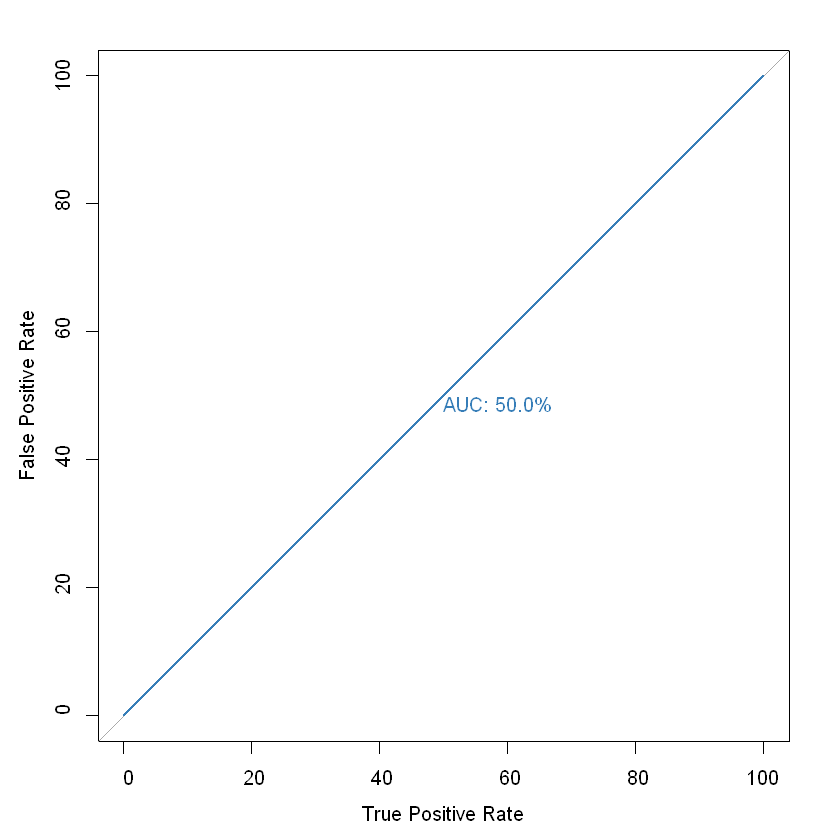

In [202]:
#CHS model for data with 50 variables

logit_CHS_sim <- glm(BANKRUPTCY ~ NIMTA + LTMTA + CASHMTA + RSIZE + PRICE + MB + SIGMA + EXCESSRETURN, 
                 family="binomial", data=train_data_sim2)

a1_sim_50 <- summary(logit_CHS_sim$aic)                         #reporting AIC for CHS with 50 variables in the data
AIC_CHS_sim <- a1_sim_50[6]
AIC_CHS_sim <- unname(AIC_CHS_sim)
print("AIC Simulation Study N.2")
AIC_CHS_sim

probabilities_sim <- logit_CHS_sim %>% predict(test_data_sim2, type = "terms")
predicted_classes_sim <- ifelse(probabilities_sim > 0.5, "1", "0")
ar_logit_sim <- mean(predicted_classes_sim == test_data_sim2$BANKRUPTCY)          
print("Accuracy Rate Simulation Study N.2")
ar_logit_sim                                                     #Accuracy Rate for CHS with 50 variables

library(pROC)
roc(train_data_sim2$BANKRUPTCY, logit_CHS_sim$fitted.values, plot = TRUE, legacy.axes = TRUE,
    percent = TRUE, xlab = "True Positive Rate",                #plotting ROC for CHS
    ylab = "False Positive Rate", col = "#377eb8", lwd = 2,      
    print.auc = TRUE)                                           #AUC for CHS with 50 variables in the data

##### Comparison between LASSO and CHS with 50 Covariates

LASSO outperforms CHS by large margin. LASSO: $AIC = 2.302$, $Accuracy Rate = 0.7733$ and $AUC = 0.8571$. CHS: $AIC = 1251$, $Accuracy Rate = 0.5181$ and $AUC = 0.500$.

In [203]:
# Comparing LASSO and CHS model

#Lasso with 50 covariates
#`LASSO(50 variables)` <-c(AICc_sim, ar_Lasso_sim, AUC_Lasso_sim)

#CHS with 50 covariates
ar_logit_sim <- 0.5181 
AIC_CHS_sim <- "1251"
AUC_CHS_sim <- "0.500"

`CHS(50)`<-c(AIC_CHS_sim, ar_logit_sim, AUC_CHS_sim)

A <- cbind(`LASSO(50 covariates)`, `CHS(50)`)
A <- as.data.frame(A)
rownames(A) <- c("AIC", "Accuracy Rate", "AUC")
A

,LASSO(50 covariates),CHS(50)
,<chr>,<chr>
AIC,2.302,1251
Accuracy Rate,0.7733,0.5181
AUC,0.8571,0.500


### 5. Conclusion:

To sum up the results from above, we saw that the advanced variable selection technique, the "LASSO" model outperforms traditional statistical models, such as the logistic regression, when it comes to predicting risk of default and bankruptcy. One of the main advantages of this method, is the ability to shrink the coefficients in the initial regression models that are not statistically significant. That is, it eliminates the variables which are not relevant for bankruptcy forecasting models. This is of great importance because in the financial forecasting models there is a large set of primary explanatory variables specified. Another noticeable advantage is the prediction accuracy of this model. When compared with other already defined models in the finance literature, such as the CHS model, it has a much better prediction accuracy. Especially when we increase the number of variables in the data. In the second part of the simulation study, we saw that it outperforms the CHS model by large margin. Therefore, as stated by the authors in the paper, the inclusion of this state of the art variable selection technique helps shape the bankruptcy forecasting models in a more precise way, making it more reliable for both policy makers and the firms themselves.

### 6. References:

Shaonan Tian, Yan Yu & Hui Guo. (2014). *Variable Selection and Corporate Bankruptcy Forecasts.* Journal of Banking & Finance.